In [2]:
%pip install anytree

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import pickle
from pathlib import Path
import os
import pprint
from anytree import Node, RenderTree
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib
import scipy 

For future iterations of this I might change the scheme to a deep directory based approach.    
Then iterations would be named `1.pickle`, `2.pickle` and be stored in deep directories like:    
`"Experiment_name/config1/config2/config3/config4/1.pickle"`    
This way I could just split the name accross the folder separator and have all the setting values, then the only thing I need is a list that gives me the correct setting-value assignment, which sounds a lot easier.

# Helper functions

In [4]:
def unpickle(filepath : str):
    file_object = open(filepath, "rb")
    results = pickle.load(file_object)
    file_object.close()
    return results

In [5]:
def extract_setting_from_name(name :str, naming_schema : list):
    result = {}
    # Main assumption for the naming schema: parameters are strictly separated by underscores '_'
    for value, setting in zip(name.split("_"), naming_schema):
        result[setting] = value
    return result
    

In [6]:
def load_results(directory, experiment_name, naming_schema=None, regex_scheme=None):
    path = Path(directory)

    dirs = [e for e in path.iterdir() if e.is_dir() and not str(e) == '.ipynb_checkpoints']
    subdirs = {str(path): [e for e in path.iterdir() if e.is_dir()] for path in dirs}
    
    relevant_subdirs = subdirs[os.path.join(directory, experiment_name)]
    relevant_subdirs.sort()
    #result_filename = '*.pickle'
    pickle_dirs = list()
    for subdir in relevant_subdirs:
        if regex_scheme:
            pickle_dirs.extend(sorted(subdir.glob(regex_scheme)))
        else:
            pickle_dirs.extend(sorted(subdir.glob("*.pickle")))
    results = []
    if not naming_schema is None:
        all_attributes = [extract_setting_from_name(subdir.name, naming_schema) for subdir in relevant_subdirs]    
        for attributes, pick in zip(all_attributes, pickle_dirs):
            try:
                unpickled_stuff = unpickle(pick)
                results.append({'attributes': attributes, 'results': unpickled_stuff})
            except:
                # Sometimes there were unknown issues with the pickle files, in those instances we re-ran training
                print("Catastrophic failure")
    else:
        for pick in pickle_dirs:
            try:
                unpickled_stuff = unpickle(pick)
                results.append({'results': unpickled_stuff})
            except:
                # Sometimes there were unknown issues with the pickle files, in those instances we re-ran training
                print("Catastrophic failure")
    return results


In [7]:
def deep_dict_get(data : dict, path : str):
    """
    path a slash ('/') separated path down to 
    """
    temp = data.copy()
    for entry in path.split("/"):
        # Catches leading '/' in tree printing
        if entry == '':
            continue
        temp = temp[entry]
    return temp

In [8]:
def compare_values(d1 : dict, d2 : dict, path : str):
    v1 = deep_dict_get(d1, path)
    v2 = deep_dict_get(d2, path)
    # Sanity check 1
    if not type(v1) == type(v2):
        return False
    else:
        # This can potentially cause errors when comparing lists of lists (or Tensors/Arrays)
        return v1 == v2

In [9]:
def create_common_root_list(root : str, values : list):
    return [f"{root}/{val}" for val in values]

# Main functions    
What features do I need?    
- ~~Show a structure tree of the results (i.e. experiment settings and result values)~~~
- ~~Filtering by setting, given a key~~
- ~~Filtering by values, given a key~~
- Create selected statistics (mean/med/std/quartiles/...) for certain values/keys
- Apply a function to certain values/keys and return the results (e.g. Eigendecomposition/Normalization/...)
- ~~Group all entries that share settings/values~~
- 

In [10]:
def generate_tree_structure(data, parent=None):
    # Solved through recursively going deeper into the data structure and then returning the leafs if at the end

    if parent is None and not len(data.keys()) == 1:
        parent = Node("root")
    elif parent is None:
        parent = Node(list(data.keys())[0])
        data = data[list(data.keys())[0]]
    
    # Recursion condition
    # If there are any dictionaries inside then go deeper
    if not any([type(data[entry]) == dict for entry in data]):
        for entry in data:
            Node(entry, parent=parent) 
    else:
        for entry in data:
            if type(data[entry]) == dict:
                branch = Node(entry, parent=parent)
                generate_tree_structure(data[entry], parent=branch)
            else:
                Node(entry, parent=parent)
    return parent
    

In [11]:
def group_by(list_of_data : list, path, value=None):
    """
    value : If None, make subgroups of equal values. 
            Otherwise return a single group where value is matched
    """
    grouped_data = {}

    if not value is None:
        grouped_data[f"{path} = {value}"] = [data for data in list_of_data if deep_dict_get(data, path) == value]
    else:    
        finished_values = list()
        for data in list_of_data:
            value = deep_dict_get(data, path)
            if f"{path} = {value}" in grouped_data.keys():
                grouped_data[f"{path} = {value}"].append(data)
            else:
                grouped_data[f"{path} = {value}"] = list()
                grouped_data[f"{path} = {value}"].append(data)
            #if not value in finished_values:
            #    grouped_data[f"{path} = value"] = [data for data in list_of_data if deep_dict_get(data, path) == value]
            #    finished_values.append(value)
    return grouped_data

In [12]:
def dict_compare(d1, d2):
    # Checking for empty list in d2, i.e. initial value
    if not type(d1) == type(d2):
        return False
    return all((d1.get(k) == v for k, v in d2.items()))
        

# Could contain an alternative head as (list_of_data : list, paths : [list, dict], values : None) 
# where paths-values would require a 1-to-1 correspondence. 
# But this could quickly become error prone on the user side...
def group_by_multiple(list_of_data : list, paths):
    grouped_data = {}
    # Grouping without values
    if type(paths) == list:
        finished_values = list()
        for data in list_of_data:
            paths_vals = {path : deep_dict_get(data, path) for path in paths}
            # not any X <=> all not X
            # i.e. only succeeds when this combination didn't exist before
            if not any([dict_comapare(paths_vals, fin_val) for fin_val in finished_values]):
                grouped_data[" ; ".join([f"{path} = {paths_vals[path]}" for path in paths_vals])] = [data]
            else:
                grouped_data[" ; ".join([f"{path} = {paths_vals[path]}" for path in paths_vals])].append(data)

    # Grouping by path-value combinations
    # Only returns the group where all those pairs are true
    elif type(paths) == dict:
        # The keys will contain the paths
        # The values will be the corresponding expected values
        # Yes, this could be a one-liner with a very neat nested list creation, 
        #  but I chose readability with temporary variables over it.
        good_data = list()
        for data in list_of_data:
            if all([deep_dict_get(data, path) == paths[path] for path in paths]):
                good_data.append(data)
        grouped_data[" ; ".join([f"{path} = {paths[path]}" for path in paths])] = good_data
    return grouped_data

In [13]:
def filter_by(list_of_data : list, path : str, value):
    filtered_data = list()
    for data in list_of_data:
        if deep_dict_get(data, path) == value:
            filtered_data.append(data)
    return filtered_data

In [14]:
def filter_value(list_of_data : list, path : str):
    """
        returns a list of the target value from each data dict
    """
    list_of_values = list()
    for data in list_of_data:
        list_of_values.append(deep_dict_get(data, path))
    return list_of_values

# Things I want to check
 - **Hardcoded setting**: Do the metrics have the same order as MCMC?
 - **CO2**: Also check the order
 - **CO2**: Check the prediction of future datapoints for each favourite metric 
 - **Kernel search**: How do the kernels found by the metrics perform according to MCMC?
 - (Kernel search: How do the kernels found by the metrics predict the future datapoints?)
 - **LODE**: Does Laplace find the most appropriate Differential equation? I.e. the correct numbers of parameters?

# Load results

In [16]:
#all_results = load_results('results', "hardcoded", regex_scheme="results.pickle")
all_results = load_results('results_pre_vacation/results', "hardcoded", regex_scheme="results.pickle")
#all_results = load_results('results_small_experiment', "hardcoded45", regex_scheme="results.pickle")

postfix = ""
result_tree = generate_tree_structure(all_results[0]).descendants

In [17]:
all_results[0]["results"]["attributes"].keys()#["results"][0]["Laplace"]["PER"].keys()#["results"][2]#.keys()#["Laplace"].keys()

dict_keys(['eval_START', 'eval_END', 'eval_COUNT', 'optimizer', 'train_iters', 'LR', 'BFGS', 'data_gen'])

In [48]:
#naming_schema = ["Metric", "Kernel_search", "train_data_ratio", "Data_kernel", "weights", "Variance_list", "eval_START", "eval_END", "eval_COUNT", "optimizer", "train_iterations", "LR", "Noise", "Data_scaling", "BFGS"]
#all_results = load_results('results', "hardcoded", regex_scheme="results.pickle")
#
#postfix = ""
#result_tree = generate_tree_structure(all_results[0]).descendants


# What do I want to know?
# 1.) Does each metric recognize the correct kernels?
# 1.1.) If not: Why?
# 2.) Is the order I was talking about true?
# 2.1.) i.e. MLL > Laplace/AIC >=? MCMC
# 3.) Are models with redundant parameters more punished than others? Especially the 2SIN vs 3SIN case
# 4.) Make a ranking sheet per dataset where the models are compared _within_ a metric to see if there are similarities visible or something
#  
model_kernels = ["PER", "PER*SE", "MAT32+MAT52", "SE", "MAT32", "MAT32+SE", "MAT32*SE"]
model_kernels = ["PER", "PER*SE", "SE", "MAT32", "MAT32+SE", "MAT32*SE"]
data_kernels = ["SE", "RQ", "MAT32", "MAT52", "SE * SE",
               "SE+SE", "MAT32+SE", "MAT52+SE", "MAT32*SE", "PER",
               "PER*SE", "(SE+RQ)*PER", "SE+SE+SE", "MAT32+(MAT52*PER)"]
#data_kernels = ["SE", "RQ", "MAT32", "MAT52", "SE*SE",
#               "SE+SE", "MAT32+SE", "MAT52+SE", "MAT32*SE", "PER",
#               "PER*SE", "(SE+RQ)*PER", "SE+SE+SE", "MAT32+(MAT52*PER)"]
dataset_sizes = [5, 10, 20, 30, 50, 70, 100, 150, 200]
#data_kernels = ["MAT52", "RQ", "SE", "MAT32", "SE*SE"]
#dataset_sizes = [5, 10, 20, 30]#[5, 10, 20, 30, 50, 70, 100, 150, 200]
metrics = ["MC", "AIC", "BIC", "MLL", "MAP",  {"Laplace_prior": [0.0, -1.0, "BIC"]}] # {"Laplace": [0.0, 2.0, "BIC"]},
#dataset_sizes = [5, 10, 20, 30, 50, 70, 100, 150, 200] 
data_model_zip = zip(data_kernels, model_kernels[:-1])




print("1.) How far away (by varying metrics) is each metric to MCMC?")

all_replaced_dict = {-1.0: list(), 0.0: list(), "BIC": list()} 
# Iterate over all datasets
mcmc_closeness_dict = {data_gen_kernel:{datasize:list() for datasize in dataset_sizes} for data_gen_kernel in data_kernels}
for main_dict in all_results:
    data_gen_kernel = main_dict["results"]["attributes"]["data_gen"]
    dataset_size = main_dict["results"]["attributes"]["eval_COUNT"]
    if any([2.0 in main_dict["results"]["results"][0]["Laplace_prior"][model_kernel].keys() for model_kernel in main_dict["results"]["results"][0]["Laplace_prior"].keys()]):
        print("This happened")
        print(dataset_size)
        continue
    #if not data_gen_kernel in ["SE", "RQ", "MAT32", "MAT52", "SE*SE"]:
    #    continue
    for run in main_dict["results"]["results"]:
        run_list = dict()
        # Do this comparison for each model kernel
        for metric in metrics:
            intra_metric_ranking = list()
            if isinstance(metric, dict):
                metric_name = list(metric.keys())[0]
                for threshold in metric[metric_name]:
                    intra_metric_ranking = list()
                    for model_kernel in model_kernels:
                        all_replaced = run[metric_name][model_kernel][threshold]["details"]['num_replaced'] == len(run[metric_name][model_kernel][threshold]["details"]['parameter list'])
                        all_replaced_dict[threshold].append(all_replaced)
                        intra_metric_ranking.append((run[metric_name][model_kernel][threshold]['loss'], f"{model_kernel}"))
                    # For ranking
                    #run_list[f"{metric_name}_{threshold}"] = sorted(intra_metric_ranking, key=lambda x:x[0])#, reverse=True)   
                    # For model evidence
                    run_list[f"{metric_name}_{threshold}"] = intra_metric_ranking
            else:
                for model_kernel in model_kernels:
                    if metric in ["AIC", "BIC"]:
                        intra_metric_ranking.append((-run[metric][model_kernel]['loss'], model_kernel))
                    else:
                        intra_metric_ranking.append((run[metric][model_kernel]['loss'], model_kernel))
                # For ranking
                #run_list[metric] = sorted(intra_metric_ranking, key=lambda x:x[0])
                # For model evidence
                run_list[metric] = intra_metric_ranking
        mcmc_closeness_dict[data_gen_kernel][dataset_size].append(run_list)


with open("evaluation/temp_storage/mcmc_closeness_dict.pickle", "wb") as f:
    pickle.dump(mcmc_closeness_dict, f)
"""


print("1.) Does each metric recognize the correct kernel?")
# 1.) Does each metric recognize the correct kernel?
# Iterate over all datasets
results_table = {datasize: {f"{metric}{postfix}":{"RR": list(), "RR3":list(), "runtime": -1} for metric in metrics} for datasize in dataset_sizes} 
#for main_dict in all_results:
# Iterate over all kernels I tried
#for model_kernel in ['C*C*RBF','C*RBF','C*SIN','C*SIN + C*SIN','C*SIN + C*SIN + C*SIN','SIN*RBF']:
#print(main_dict["results"]["attributes"]["data_gen"])
for data_num in dataset_sizes:
    # Filter for dataset size
    data_500 = group_by_multiple(all_results, {'/results/attributes/eval_COUNT': data_num})
    data_500_key = list(data_500.keys())[0]

    for result in data_500[data_500_key]:
        if not deep_dict_get(result, "results/attributes/data_gen") in data_kernels:
            continue
        for metric in metrics:
            if result["results"]["attributes"]["data_gen"] == max([(result['results'][metric][model_kernel]['loss'], model_kernel) for model_kernel in model_kernels])[-1]:
                results_table[data_num][f"{metric}{postfix}"]["RR"].append(True)
            else:
                results_table[data_num][f"{metric}{postfix}"]["RR"].append(False)
            sorted_results = sorted([(result['results'][metric][model_kernel]['loss'], model_kernel) for model_kernel in model_kernels], key=lambda x:x[0], reverse=True)
            top3 = sorted_results[:3]#sorted([(result['results'][metric][model_kernel]['loss'], model_kernel) for model_kernel in model_kernels])[:3]
            if result["results"]["attributes"]["data_gen"] in [t[1] for t in top3]:
                results_table[data_num][f"{metric}{postfix}"]["RR3"].append(True)
            else:
                results_table[data_num][f"{metric}{postfix}"]["RR3"].append(False)
    #print(f"{metric}\t {max([(main_dict['results'][metric][model_kernel]['loss'], model_kernel) for model_kernel in model_kernels])}")

print("===============================")
print("2.) Is the order I was talking about true? i.e. what is the order or the values for MLL, AIC, Laplace and where does MC lie at?")
# 2.) Is the order I was talking about true? i.e. what is the order or the values for MLL, AIC, Laplace and where does MC lie at?
#     It should be ordered AIC > MLL > Laplace
#     And somewhere in between there should be MC
# Iterate over all datasets
for main_dict in all_results:
    print(main_dict["results"]["attributes"]["data_gen"])
    # Do this comparison for each model kernel
    #["SE", "PER", "MAT32", "PER*SE", "PER+SE", "MAT32*PER", "MAT32+PER", "MAT32+SE", "MAT32*SE"]
    for model_kernel in model_kernels:
        ranking = [(main_dict['results'][metric][model_kernel]['loss'], metric) for metric in metrics]
        ranking = sorted(ranking, key=lambda x:x[0], reverse=True)
        # Check if it either is MLL > Laplace > AIC (this happens if MLL is negative) OR AIC > MLL > Laplace 
        #if not (main_dict['results']["MLL"][model_kernel]['loss'] > main_dict['results']["Laplace"][model_kernel]['loss'] > main_dict['results']["AIC"][model_kernel]['loss']) and not (main_dict['results']["AIC"][model_kernel]['loss'] > main_dict['results']["MLL"][model_kernel]['loss'] > main_dict['results']["Laplace"][model_kernel]['loss']) :
        print(f"{model_kernel}\t {ranking}")

#print("===============================")
#print("3.) Are models with redundant parameters more punished than others? Especially the 2SIN vs 3SIN case")
## 3.) Are models with redundant parameters more punished than others? Especially the 2SIN vs 3SIN case 
#
## Iterate over all datasets
#for main_dict in all_results:
#    for metric in ["Laplace", "AIC", "Laplace_prior"]:
#        print(metric)
#        for pair in data_model_zip:#[('C*RBF', 'C*C*RBF'), ('C*SIN', 'C*SIN + C*SIN + C*SIN'), ('C*SIN + C*SIN', 'C*SIN + C*SIN + C*SIN'), ('C*SIN', 'C*SIN + C*SIN')]:
#            met_1 = main_dict['results'][metric][pair[0]]['loss'] 
#            met_2 = main_dict['results'][metric][pair[1]]['loss'] 
#            if not met_1 > met_2:
#                print(f"{main_dict['results']['attributes']['data_gen']} \t - {pair}")
        

print("===============================")
print("4.) Make a ranking per dataset how each model kernel was rated")

# 4.) Make a ranking per dataset how each model kernel was rated 
# Iterate over all datasets
confusion_matrix_data = {datasize: {f"{metric}{postfix}":{data_kernel : None for data_kernel in data_kernels} for metric in metrics} for datasize in dataset_sizes} 
for data_num in dataset_sizes:
    print(data_num)
    # Filter for dataset size
    data_500 = group_by_multiple(all_results, {'/results/attributes/eval_COUNT': data_num})
    data_500_key = list(data_500.keys())[0]

    for result in data_500[data_500_key]:
        print(result["results"]["attributes"]["data_gen"])
        for metric in metrics:
        # Do this ranking for each metric 
            print(metric)
            ranking = [(result['results'][metric][model_kernel]['loss'], model_kernel) for model_kernel in model_kernels] 
            key_fkt = lambda x: x[0]
            pprint.pprint(sorted(ranking, key=key_fkt, reverse=True))

            def div2(input, doit):
                if doit:
                    return input/2
                else:
                    return input

            confusion_matrix_data[data_num][f"{metric}{postfix}"][result["results"]["attributes"]["data_gen"]] = [div2(result['results'][metric][model_kernel]['loss'].item(), metric in ["AIC", "BIC"]) for model_kernel in model_kernels]
            print("===============")

print("===============================")
print("5.) Runtime of each metric")

# Do this ranking for each metric 
for data_num in dataset_sizes:
    # Filter for dataset size
    data_500 = group_by_multiple(all_results, {'/results/attributes/eval_COUNT': data_num})
    data_500_key = list(data_500.keys())[0]

    for result in data_500[data_500_key]:
        for metric in metrics:
            #print(metric)
            if metric in ["Laplace", "Laplace_prior", "BIC"]:
                runtime_list = [result['results'][metric][model_kernel]['details']['Total time'] + result['results'][metric][model_kernel]['Train time']  for model_kernel in model_kernels]
            elif metric in ["MLL", "MAP"]:
                runtime_list = [result['results'][metric][model_kernel]['Train time']  for model_kernel in model_kernels]
            else:
                runtime_list = [result['results'][metric][model_kernel]['details']['Total time'] for model_kernel in model_kernels] 
            results_table[data_num][metric]["runtime"] = np.average(runtime_list)

"""

1.) How far away (by varying metrics) is each metric to MCMC?
This happened
100
This happened
100
This happened
100
This happened
100
This happened
100
This happened
150
This happened
150
This happened
150
This happened
150
This happened
150
This happened
200
This happened
200
This happened
200
This happened
200
This happened
200
This happened
50
This happened
70
This happened
70
This happened
70
This happened
70
This happened
70


'\n\n\nprint("1.) Does each metric recognize the correct kernel?")\n# 1.) Does each metric recognize the correct kernel?\n# Iterate over all datasets\nresults_table = {datasize: {f"{metric}{postfix}":{"RR": list(), "RR3":list(), "runtime": -1} for metric in metrics} for datasize in dataset_sizes} \n#for main_dict in all_results:\n# Iterate over all kernels I tried\n#for model_kernel in [\'C*C*RBF\',\'C*RBF\',\'C*SIN\',\'C*SIN + C*SIN\',\'C*SIN + C*SIN + C*SIN\',\'SIN*RBF\']:\n#print(main_dict["results"]["attributes"]["data_gen"])\nfor data_num in dataset_sizes:\n    # Filter for dataset size\n    data_500 = group_by_multiple(all_results, {\'/results/attributes/eval_COUNT\': data_num})\n    data_500_key = list(data_500.keys())[0]\n\n    for result in data_500[data_500_key]:\n        if not deep_dict_get(result, "results/attributes/data_gen") in data_kernels:\n            continue\n        for metric in metrics:\n            if result["results"]["attributes"]["data_gen"] == max([(result[

In [240]:
for threshold in [0.0, -1.0, "BIC"]:
    print(f"{threshold}:\t{(len(all_replaced_dict[threshold]) - np.count_nonzero(all_replaced_dict[threshold]))/len(all_replaced_dict[threshold])}")

0.0:	0.7545173745173746
-1.0:	0.26893178893178893
BIC:	0.03086229086229086


In [241]:
with open("evaluation/temp_storage/mcmc_closeness_dict.pickle", "rb") as f:
    mcmc_closeness_dict = pickle.load(f)

In [21]:
# How high is the sum of the difference of the likelihoods for wrongly ranked kernels?
# 
str_metrics = ["AIC", "BIC", "MLL", "MAP", "Laplace_prior_0.0", "Laplace_prior_-1.0", "Laplace_prior_BIC"]
dataset_sizes = [5, 10, 20, 30, 50, 70, 100, 150, 200] 
#dataset_sizes = [5, 10, 20, 30]
mismatch_results_dict = dict()
total_mismatch_results = {datasize:{metric:list() for metric in str_metrics} for datasize in dataset_sizes} 
for data_kernel in mcmc_closeness_dict:
    for dataset_size in dataset_sizes:
        mismatch_results = {datasize:{metric:list() for metric in str_metrics} for datasize in dataset_sizes} 
        for run in mcmc_closeness_dict[data_kernel][dataset_size]:
            for metric in str_metrics:
                # Check the ranking of the metric to MCMC 
                MCMC_ranking_list = [entry[1] for entry in run["MC"]]
                # For each run in metric, check how high the loss difference in the mismatch is
                metric_ranking_difference = [abs(run["MC"][i][0] - run["MC"][MCMC_ranking_list.index(entry[1])][0]) for i, entry in enumerate(run[metric])]

                mismatch_results[dataset_size][metric].append(metric_ranking_difference)
                total_mismatch_results[dataset_size][metric].append(metric_ranking_difference)

        mismatch_results_dict[data_kernel] = mismatch_results 


for dataset_size in total_mismatch_results:
    print(dataset_size)
    for metric in total_mismatch_results[dataset_size]:
        statistic = [sum(run[:3]) for run in total_mismatch_results[dataset_size][metric]]
        print(f"{metric} - {np.mean(statistic)} \pm {np.std(statistic)}")

5
AIC - 55.769798278808594 \pm 83.93067169189453
BIC - 55.87862777709961 \pm 83.97467041015625
MLL - 82.85609436035156 \pm 168.83082580566406
MAP - 53.25863265991211 \pm 64.10964965820312
Laplace_prior_0.0 - 54.4403190612793 \pm 72.83552551269531
Laplace_prior_-1.0 - 64.76472473144531 \pm 78.8877944946289
Laplace_prior_BIC - 69.21089172363281 \pm 78.2470932006836
10
AIC - 67.03619384765625 \pm 63.52206802368164
BIC - 66.52098846435547 \pm 63.64229965209961
MLL - 88.6899642944336 \pm 88.74903106689453
MAP - 56.56293487548828 \pm 48.234092712402344
Laplace_prior_0.0 - 64.93993377685547 \pm 75.56813049316406
Laplace_prior_-1.0 - 73.04898071289062 \pm 77.76058959960938
Laplace_prior_BIC - 101.12925720214844 \pm 121.08197021484375
20
AIC - 447.5976867675781 \pm 713.7140502929688
BIC - 424.2874755859375 \pm 700.5272216796875
MLL - 430.1659240722656 \pm 717.5907592773438
MAP - 245.84722900390625 \pm 287.9297790527344
Laplace_prior_0.0 - 276.0773010253906 \pm 340.7463684082031
Laplace_prior_-1

/home/besginow/anaconda3/envs/sage/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/besginow/anaconda3/envs/sage/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/besginow/anaconda3/envs/sage/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/besginow/anaconda3/envs/sage/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/besginow/anaconda3/envs/sage/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [41]:
# How far away from the first place is the first place in each metric
# Do this for each entry in the metric? Do this for the top-k entries?
str_metrics = ["AIC", "BIC", "MLL", "MAP", "Laplace_prior_0.0", "Laplace_prior_-1.0", "Laplace_prior_BIC"]
dataset_sizes = [5, 10, 20, 30, 50, 70, 100, 150, 200] 
#dataset_sizes = [5, 10, 20, 30]
ranking_results_dict = dict()
spearr_dict = dict()
total_ranking_results = {datasize:{metric:list() for metric in str_metrics} for datasize in dataset_sizes} 
for data_kernel in mcmc_closeness_dict:
    for dataset_size in dataset_sizes:
        ranking_results = {datasize:{metric:list() for metric in str_metrics} for datasize in dataset_sizes} 
        for run in mcmc_closeness_dict[data_kernel][dataset_size]:
            for metric in str_metrics:
                # Check the ranking of the metric to MCMC 
                MCMC_ranking_list = [entry[1] for entry in run["MC"]]
                metric_ranking_difference = [abs(i - MCMC_ranking_list.index(entry[1])) for i, entry in enumerate(run[metric])]

                ranking_results[dataset_size][metric].append(metric_ranking_difference)
                total_ranking_results[dataset_size][metric].append(metric_ranking_difference)

        ranking_results_dict[data_kernel] = ranking_results 


In [47]:
total_ranking_results
for dataset_size in total_ranking_results:
    print(dataset_size)
    for metric in total_ranking_results[dataset_size]:
        statistic = [sum(run[:]) for run in total_ranking_results[dataset_size][metric]]
        print(f"{metric} - {np.mean(statistic)} \pm {np.std(statistic)}")

5
AIC - 0.0 \pm 0.0
BIC - 0.0 \pm 0.0
MLL - 0.0 \pm 0.0
MAP - 0.0 \pm 0.0
Laplace_prior_0.0 - 0.0 \pm 0.0
Laplace_prior_-1.0 - 0.0 \pm 0.0
Laplace_prior_BIC - 0.0 \pm 0.0
10
AIC - 0.0 \pm 0.0
BIC - 0.0 \pm 0.0
MLL - 0.0 \pm 0.0
MAP - 0.0 \pm 0.0
Laplace_prior_0.0 - 0.0 \pm 0.0
Laplace_prior_-1.0 - 0.0 \pm 0.0
Laplace_prior_BIC - 0.0 \pm 0.0
20
AIC - 0.0 \pm 0.0
BIC - 0.0 \pm 0.0
MLL - 0.0 \pm 0.0
MAP - 0.0 \pm 0.0
Laplace_prior_0.0 - 0.0 \pm 0.0
Laplace_prior_-1.0 - 0.0 \pm 0.0
Laplace_prior_BIC - 0.0 \pm 0.0
30
AIC - 0.0 \pm 0.0
BIC - 0.0 \pm 0.0
MLL - 0.0 \pm 0.0
MAP - 0.0 \pm 0.0
Laplace_prior_0.0 - 0.0 \pm 0.0
Laplace_prior_-1.0 - 0.0 \pm 0.0
Laplace_prior_BIC - 0.0 \pm 0.0
50
AIC - 0.0 \pm 0.0
BIC - 0.0 \pm 0.0
MLL - 0.0 \pm 0.0
MAP - 0.0 \pm 0.0
Laplace_prior_0.0 - 0.0 \pm 0.0
Laplace_prior_-1.0 - 0.0 \pm 0.0
Laplace_prior_BIC - 0.0 \pm 0.0
70
AIC - nan \pm nan
BIC - nan \pm nan
MLL - nan \pm nan
MAP - nan \pm nan
Laplace_prior_0.0 - nan \pm nan
Laplace_prior_-1.0 - nan \pm nan
L

In [49]:
#scipy.stats.kendalltau([entry[1] for entry in result_dict["MAT32"][0]["MC"]], [entry[1] for entry in result_dict["MAT32"][0]["AIC"]])
#"Laplace_0.0", "Laplace_2.0", "Laplace_BIC"
#
str_metrics = ["AIC", "BIC", "MLL", "MAP", "Laplace_prior_0.0", "Laplace_prior_-1.0", "Laplace_prior_BIC"]
dataset_sizes = [5, 10, 20, 30, 50, 70, 100, 150, 200]
#dataset_sizes = [5, 10, 20, 30, 50, 70, 100, 150, 200] 
kendall_tau_dict = dict()
spearr_dict = dict()
total_tau_results = {datasize:{metric:list() for metric in str_metrics} for datasize in dataset_sizes} 
total_spearr_results = {datasize:{metric:list() for metric in str_metrics} for datasize in dataset_sizes}
for data_kernel in mcmc_closeness_dict:
    for dataset_size in dataset_sizes:
        tau_results = {datasize:{metric:list() for metric in str_metrics} for datasize in dataset_sizes} 
        spearr_results = {datasize:{metric:list() for metric in str_metrics} for datasize in dataset_sizes}
        for run in mcmc_closeness_dict[data_kernel][dataset_size]:
            for metric in str_metrics:
                # Correlates the ranking of the model kernels to the one generated by MCMC
                #tau = scipy.stats.kendalltau([entry[1] for entry in run["MC"]], [entry[1] for entry in run[metric]])
                #spearr = scipy.stats.spearmanr([entry[1] for entry in run["MC"]], [entry[1] for entry in run[metric]])
                # Correlates the model evidence to the value of the respective metric
                # I now do the -entry thing already when loading the data for AIC/BIC
                #if metric in ["AIC", "BIC"]:
                #    tau = scipy.stats.kendalltau([entry[0] for entry in run["MC"]], [-entry[0].detach().numpy() for entry in run[metric]])
                #    spearr = scipy.stats.spearmanr([entry[0] for entry in run["MC"]], [-entry[0].detach().numpy() for entry in run[metric]])
                #else:
                tau = scipy.stats.kendalltau([entry[0] for entry in run["MC"]], [entry[0].detach().numpy() for entry in run[metric]])
                spearr = scipy.stats.spearmanr([entry[0] for entry in run["MC"]], [entry[0].detach().numpy() for entry in run[metric]])
                tau_results[dataset_size][metric].append(tau.statistic)
                total_tau_results[dataset_size][metric].append(tau.statistic)
                spearr_results[dataset_size][metric].append(spearr.statistic)
                total_spearr_results[dataset_size][metric].append(spearr.statistic)
        kendall_tau_dict[data_kernel] = tau_results 
        spearr_dict[data_kernel] = spearr_results 


In [50]:
# By choosing the top 3-4 metrics here I can select which ones I want to put in the line plot
import itertools
for metric in str_metrics:
    print(f"{metric} - {np.round(np.mean(list(itertools.chain.from_iterable([total_tau_results[dataset_size][metric] for dataset_size in total_tau_results]))), 4)} \pm {np.round(np.std(list(itertools.chain.from_iterable([total_tau_results[dataset_size][metric] for dataset_size in total_tau_results]))), 4)}")
    #print(f"{metric} - {np.round(np.mean(list(itertools.chain.from_iterable([total_spearr_results[dataset_size][metric] for dataset_size in total_spearr_results]))), 4)} \pm {np.round(np.std(list(itertools.chain.from_iterable([total_spearr_results[dataset_size][metric] for dataset_size in total_spearr_results]))), 4)}")

AIC - 0.0595 \pm 0.3205
BIC - 0.0861 \pm 0.3151
MLL - 0.1129 \pm 0.3181
MAP - 0.0878 \pm 0.3055
Laplace_prior_0.0 - 0.0956 \pm 0.3165
Laplace_prior_-1.0 - 0.0333 \pm 0.3107
Laplace_prior_BIC - -0.0256 \pm 0.3056


/home/besginow/anaconda3/envs/sage/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/besginow/anaconda3/envs/sage/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/besginow/anaconda3/envs/sage/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/besginow/anaconda3/envs/sage/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/besginow/anaconda3/envs/sage/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Tau')

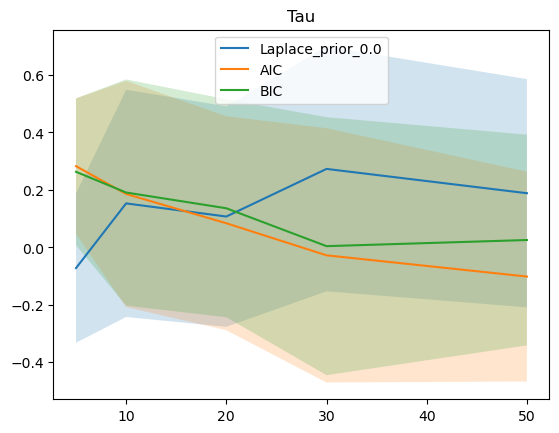

In [36]:
# line plot with the means across varying dataset sizes

tau_mean_dict = {metric:list() for metric in str_metrics}
tau_std_dict = {metric:list() for metric in str_metrics}
spearr_mean_dict = {metric:list() for metric in str_metrics}
spearr_std_dict = {metric:list() for metric in str_metrics}
for dataset_size in total_tau_results: 
    for metric in total_tau_results[dataset_size]:
        tau_mean_dict[metric].append(np.mean(total_tau_results[dataset_size][metric]))
        tau_std_dict[metric].append(np.std(total_tau_results[dataset_size][metric]))
        spearr_mean_dict[metric].append(np.mean(total_spearr_results[dataset_size][metric]))
        spearr_std_dict[metric].append(np.std(total_spearr_results[dataset_size][metric]))
        #np.std(total_tau_results[metric])
        #np.std(total_spearr_results[metric])


for metric in ["Laplace_prior_0.0", "AIC", "BIC"]:#tau_mean_dict:
    plt.plot(dataset_sizes, spearr_mean_dict[metric],  label=metric)
    plt.fill_between(dataset_sizes, torch.Tensor(spearr_mean_dict[metric]) - torch.Tensor(spearr_std_dict[metric]), torch.Tensor(spearr_mean_dict[metric]) + torch.Tensor(spearr_std_dict[metric]), alpha=0.2)
    #plt.plot(dataset_sizes, tau_mean_dict[metric],  label=metric)
    #plt.fill_between(dataset_sizes, torch.Tensor(tau_mean_dict[metric]) - torch.Tensor(tau_std_dict[metric]), torch.Tensor(tau_mean_dict[metric]) + torch.Tensor(tau_std_dict[metric]), alpha=0.2)
plt.legend(loc=9)
plt.title("Tau")
#tikzplotlib.save("evaluation/correlation_likelihood_tau.tex")

In [51]:
print(" & " + " & ".join([metric for metric in tau_mean_dict]))
for i, dataset_size in enumerate(dataset_sizes):
    row_means = [np.round(tau_mean_dict[metric][i], 3) for metric in tau_mean_dict]
    row_stds = [np.round(tau_std_dict[metric][i], 3) for metric in tau_std_dict]
    max_pos = row_means.index(max(row_means))
    row_vals_str = [f"${row_mean} \\pm {row_std}$" for row_mean, row_std in zip(row_means, row_stds)]
    row_vals_str[max_pos] = f"$\\mathbf{{{row_vals_str[max_pos][1:-1]}}}$"
    print(f"Tau \@ {dataset_size} & " + f" & ".join([str(val) for val in row_vals_str]) + "\\\\")



 & AIC & BIC & MLL & MAP & Laplace_prior_0.0 & Laplace_prior_-1.0 & Laplace_prior_BIC
Tau \@ 5 & $\mathbf{0.198 \pm 0.193}$ & $0.182 \pm 0.212$ & $0.139 \pm 0.301$ & $-0.08 \pm 0.195$ & $-0.053 \pm 0.195$ & $-0.117 \pm 0.183$ & $-0.144 \pm 0.196$\\
Tau \@ 10 & $\mathbf{0.14 \pm 0.323}$ & $0.14 \pm 0.328$ & $-0.02 \pm 0.338$ & $0.04 \pm 0.241$ & $0.109 \pm 0.317$ & $0.051 \pm 0.3$ & $-0.019 \pm 0.307$\\
Tau \@ 20 & $0.06 \pm 0.305$ & $0.095 \pm 0.308$ & $\mathbf{0.227 \pm 0.255}$ & $0.115 \pm 0.314$ & $0.077 \pm 0.312$ & $-0.013 \pm 0.308$ & $-0.056 \pm 0.319$\\
Tau \@ 30 & $-0.046 \pm 0.365$ & $-0.018 \pm 0.37$ & $0.129 \pm 0.338$ & $\mathbf{0.221 \pm 0.348}$ & $0.221 \pm 0.357$ & $0.165 \pm 0.347$ & $0.099 \pm 0.338$\\
Tau \@ 50 & $-0.083 \pm 0.3$ & $0.018 \pm 0.286$ & $0.085 \pm 0.294$ & $\mathbf{0.157 \pm 0.315}$ & $0.13 \pm 0.313$ & $0.093 \pm 0.314$ & $-0.003 \pm 0.294$\\
Tau \@ 70 & $\mathbf{nan \pm nan}$ & $nan \pm nan$ & $nan \pm nan$ & $nan \pm nan$ & $nan \pm nan$ & $nan \pm 

Text(0.5, 1.0, 'Spearr')

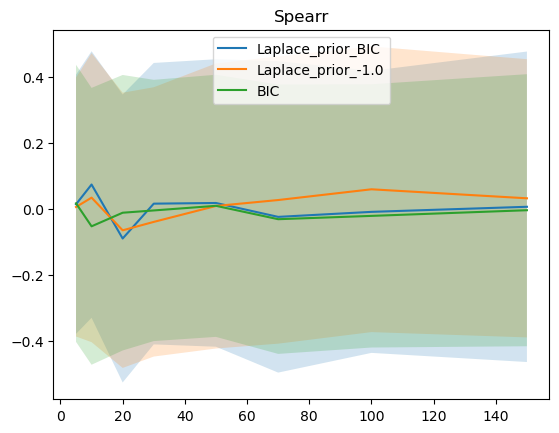

In [87]:
for metric in ["Laplace_prior_BIC", "Laplace_prior_-1.0", "BIC"]:#tau_mean_dict:
    plt.plot(dataset_sizes, spearr_mean_dict[metric], label=metric)
    plt.fill_between(dataset_sizes, torch.Tensor(spearr_mean_dict[metric]) - torch.Tensor(spearr_std_dict[metric]), torch.Tensor(spearr_mean_dict[metric]) + torch.Tensor(spearr_std_dict[metric]), alpha=0.2)
plt.legend(loc=9)
plt.title("Spearr")

In [23]:
for data_kernel in kendall_tau_dict:
    print(data_kernel)
    for metric in kendall_tau_dict[data_kernel]:
        print(f"TAU: \t{metric} - {np.mean(kendall_tau_dict[data_kernel][metric])} - {np.std(kendall_tau_dict[data_kernel][metric])}")
        print(f"R: \t{metric} - {np.mean(spearr_dict[data_kernel][metric])} - {np.std(spearr_dict[data_kernel][metric])}")
print("---------------")
for metric in total_tau_results:
    print(f"TAU: \t{metric} - {np.mean(total_tau_results[metric])} - {np.std(total_tau_results[metric])}")
    print(f"R: \t{metric} - {np.mean(total_spearr_results[metric])} - {np.std(total_spearr_results[metric])}")


SE


TypeError: unsupported operand type(s) for /: 'dict' and 'int'

# Kernel Search

## Load data

In [ ]:
Lap_results = load_results("results", "Laplace_prior")
AIC_results = load_results("results", "AIC")
BIC_results = load_results("results", "BIC")
MLL_results = load_results("results", "MLL")

In [ ]:

MLL_results = load_results("results", "MLL")

In [ ]:
all_results = {"Laplace_prior" : Lap_results, "AIC": AIC_results, "BIC": BIC_results, "MLL": MLL_results}

## Kernel recognitions

In [ ]:
#data[0]["results"]["results"]["avg test mll"]
#data[0]["results"]["results"]["MCMC approx"]
found_kernel = data[0]["results"]["results"]["final model"]# == data[0]["results"]["attributes"]["Data_kernel"]

found_kernel = found_kernel.replace("c * ", "")
# There are at most 2 summands, i.e. I don't need braces
if found_kernel.count("*") + found_kernel.count("+") <= 1:
    found_kernel = found_kernel.replace("(", "")
    found_kernel = found_kernel.replace(")", "")
found_kernel

NameError: name 'data' is not defined

In [ ]:
def shunting_yard(expression):
    output = []
    operators = []

    precedence = {'+': 1, '*': 2}

    tokens = expression.replace(' ', '')

    i = 0
    while i < len(tokens):
        if tokens[i].isalnum():
            # Handle variable names
            j = i + 1
            while j < len(tokens) and tokens[j].isalnum():
                j += 1

            output.append(tokens[i:j])
            i = j
        elif tokens[i] in '+*':
            # Handle operators
            while operators and operators[-1] in '+*' and precedence[operators[-1]] >= precedence[tokens[i]]:
                output.append(operators.pop())
            operators.append(tokens[i])
            i += 1
        elif tokens[i] == '(':
            # Handle left parentheses
            operators.append(tokens[i])
            i += 1
        elif tokens[i] == ')':
            # Handle right parentheses
            while operators and operators[-1] != '(':
                output.append(operators.pop())

            if operators and operators[-1] == '(':
                operators.pop()

            i += 1

    while operators:
        # Append remaining operators to output
        output.append(operators.pop())

    return output


class TreeNode:
    def __init__(self, value):
        self.value = value
        self.left = None
        self.right = None

def is_operator(token):
    return token in "+*"

def construct_tree(rpn_list):
    stack = []

    for token in rpn_list:
        if is_operator(token):
            node = TreeNode(token)
            node.right = stack.pop()
            node.left = stack.pop()
            stack.append(node)
        else:
            stack.append(TreeNode(token))

    return stack.pop()

def is_commutative_operator(token):
    return token in "+*"

def is_same_tree(tree1, tree2):
    if tree1 is None and tree2 is None:
        return True
    if tree1 is None or tree2 is None:
        return False

    if is_commutative_operator(tree1.value) and is_commutative_operator(tree2.value):
        return (is_same_tree(tree1.left, tree2.left) and is_same_tree(tree1.right, tree2.right)) or \
               (is_same_tree(tree1.left, tree2.right) and is_same_tree(tree1.right, tree2.left))

    return tree1.value == tree2.value and is_same_tree(tree1.left, tree2.left) and \
           is_same_tree(tree1.right, tree2.right)


# Test example
expression = '(((MAT32) * (MAT32)) + (PER))'
expression2 = '((PER) + ((MAT32) * (MAT32)))'
result = shunting_yard(expression)
result2 = shunting_yard(expression2)
result_tree = construct_tree(result)
result_tree2 = construct_tree(result2)
is_same_tree(result_tree, result_tree2)


True

In [ ]:
import re
A = '(((c * MAT32) * (c * MAT32)) + (c * PER))'
B = '((c * SE) + (c * MAT32))'
re.findall(r'\([^()]*\)', A)
# Use this to get the most inner braces
#r'\([^()]*\)'
A = A.replace("c * ", "")
#re.findall(r'\([^()]*\)', A)
A

'(((MAT32) * (MAT32)) + (PER))'

In [ ]:
res = re.findall('\((([^()]*|\(([^()]*|\([^()]*\))*\))*)\)', A)
#re.sub(whatever, replaceterm, kernel_string)
res


[('((MAT32) * (MAT32)) + (PER)', '', '')]

In [ ]:
metrics = ["MLL", "AIC", "BIC", "Laplace_prior0.0", "Laplace_prior-1.0", "Laplace_priorBIC"]
recognition_dict = {data_num : {metric : list() for metric in metrics} for data_num in [5, 10, 20, 30, 40, 50, 70, 100, 150, 200]}
for key in ["AIC", "BIC", "MLL", "Laplace_prior"]:
    current_results = all_results[key]
    for data in current_results:
        #data = group_by(all_results, '/results/attributes/eval_COUNT', data_num)
        #data_keys = list(data.keys())
        if key in ["Laplace_prior"]:
            data = group_by(data, '/results/attributes/parameter_punishment') 
        # Test likelihood 
        # Grab the "avg test mll" for each run
        test_mll = data[0]["results"]["results"]["avg test mll"]
        # Model evidence
        # Grab the "MCMC approx" for each run
        MCMC = data[0]["results"]["results"]["MCMC approx"]
        # Number of correctly found kernels
        found_kernel = data[0]["results"]["results"]["final model"]
        data_kernel = data[0]["results"]["attributes"]["Data_kernel"]

        found_kernel = found_kernel.replace("c * ", "")

        result = shunting_yard(found_kernel)
        result2 = shunting_yard(data_kernel)
        result_tree = construct_tree(result)
        result_tree2 = construct_tree(result2)
        is_same_tree(result_tree, result_tree2)



In [ ]:

print(" & ".join(["MC", "AIC", "BIC", "Laplace", "Laplace_prior"]))
print(" & ".join(list(all_the_results_tables[data_num].keys())))
for data_num in all_the_results_tables:
    result_line = f"\\multirow{{3}}{{*}}{{{data_num}}} & "
    for criterium in ["RR", "RR3", "runtime"]:
        result_line += f"{criterium}"
        for metric in all_the_results_tables[data_num]:
            if criterium in ["RR", "RR3"]:
                result_line += f" & {np.round(100*np.count_nonzero(all_the_results_tables[data_num][metric][criterium])/len(all_the_results_tables[data_num][metric][criterium]), 2)}"
            else:
                result_line += f" & {np.round(all_the_results_tables[data_num][metric][criterium], 2)}"
        result_line += "\\\\"
        print(result_line)
        result_line = " & "
    print("\\midrule")

MC & AIC & BIC & Laplace & Laplace_prior


NameError: name 'all_the_results_tables' is not defined

In [ ]:
#all_the_results_tables = copy.deepcopy(results_table)
#all_the_results_tables_bak = copy.deepcopy(all_the_results_tables)
all_the_results_tables = {data_num: dict(list(all_the_results_tables[data_num].items()) + list(results_table[data_num].items())) for data_num in all_the_results_tables}

In [ ]:
all_the_results_tables

In [ ]:

#all_the_confusion_results_bak = copy.deepcopy(all_the_confusion_results)

In [ ]:
#import copy
#all_the_confusion_results = copy.deepcopy(confusion_matrix_data)
#all_the_confusion_results = copy.deepcopy(all_the_confusion_results_bak)

In [ ]:
all_the_confusion_results = {data_num: dict(list(all_the_confusion_results[data_num].items()) + list(confusion_matrix_data[data_num].items())) for data_num in all_the_confusion_results}

In [ ]:
all_the_confusion_results

In [ ]:
fig, axs = plt.subplots(len(dataset_sizes), len(all_the_confusion_results[10]), sharey=True)
all_conf_matr_data = list()
#fig, axs = plt.subplots(1, 3, sharey=True)
for row, data_num in enumerate(dataset_sizes):#enumerate(confusion_matrix_data):
    all_conf_matr_data = list()
    for col, metric in enumerate(sorted(all_the_confusion_results[data_num])):
        all_conf_matr_data.extend([all_the_confusion_results[data_num][metric][data_kernel] for data_kernel in data_kernels])
    minmin = np.min(np.array(all_conf_matr_data).flatten())
    maxmax = np.max(np.array(all_conf_matr_data).flatten())
    for col, metric in enumerate(sorted(all_the_confusion_results[data_num])):
        #all_conf_matr_data.extend([all_the_confusion_results[data_num][metric][data_kernel] for data_kernel in data_kernels])
        im = axs[row, col].matshow([all_the_confusion_results[data_num][metric][data_kernel] for data_kernel in data_kernels], vmin=minmin, vmax=maxmax)
        #fig.colorbar(axs[row, col].matshow(single_conf_matr_data), cmap=plt.cm.GnBu)
        if row == 0:
            axs[row, col].set_xticks(range(len(model_kernels)))
            axs[row, col].set_xticklabels(model_kernels, rotation=90)
            axs[row, col].set_title(metric)
        else:
            axs[row, col].set_xticks([])
        axs[row, col].set_yticks(range(len(data_kernels)))
        if col == 0:
            axs[row, col].set_ylabel(data_num)
        axs[row, col].set_yticklabels(data_kernels)
    plt.colorbar(im)
        

#fig.colorbar(np.array(all_conf_matr_data))
#plt.colorbar(im)
fig.set_figwidth(30)
fig.set_figheight(15)
#plt.legend()

tikzplotlib.save("evaluation/confusion_matrix/allConfusionMatrix.tex")


In [ ]:
plt.close()

## statistics extraction
Extracting the test likelihood and model evidence for the plots in the next blocks

In [ ]:
# Kernelsearch: Extract the ratio of recognitions to total kernels and the MCMC results for each metric
results_dict = {}
metrics = ["MLL", "AIC", "BIC", "Laplace_prior0.0", "Laplace_prior-1.0", "Laplace_priorBIC"]
kernel_recognition_dict = {data_num : {metric : {"1" : 0, "2" : 0} for metric in metrics} for data_num in [5, 10, 20, 30, 40, 50, 70, 100, 150, 200]}
mcmc_performance_dict = {data_num : {metric : list() for metric in metrics} for data_num in [5, 10, 20, 30, 40, 50, 70, 100, 150, 200]}
test_likelihood_performance_dict = {data_num : {metric : list() for metric in metrics} for data_num in [5, 10, 20, 30, 40, 50, 70, 100, 150, 200]}
recognition_performance_dict = {data_num : {metric : list() for metric in metrics} for data_num in [5, 10, 20, 30, 40, 50, 70, 100, 150, 200]}
for data_num in [5, 10, 20, 30, 40, 50, 70, 100, 150, 200]:
    print("======================")
    results_dict[data_num] = {}
    print(data_num)
    # Verify the recognition ratio of "PER", "MAT32", "PER*SE", "PER+SE", "MAT32*PER", "MAT32+PER"
    kernel_distributions = {}
    for key in ["AIC", "BIC", "MLL", "Laplace_prior"]:
        current_results = all_results[key]
        #pprint.pprint(result_tree)
        #total_runs = len(all_results[0])
        #print(all_results[0]['results']['attributes']['Data_kernel'])
        #winners = group_by(all_results, 'results/results/final model', value='(c * PER)')['results/results/final model = (c * PER)']
        data_kernels = [("SE", "(c * SE)"), ("RQ", "(c * RQ)"), ("PER", "(c * PER)"), ("MAT32", "(c * MAT32)"), ("PER*SE", "((c * PER) * (c * SE))"), ("PER+SE", "((c * PER) + (c * SE))"), ("MAT32*PER", "((c * MAT32) * (c * PER))"), ("MAT32+PER", "((c * MAT32) + (c * PER))"),("MAT32+SE", "((c * MAT32) + (c * SE))"),("MAT32*SE", "((c * MAT32) * (c * SE))")]
        data_500 = group_by_multiple(current_results, {'/results/attributes/eval_COUNT': data_num})
        #data_0_punish = group_by(all_results, '/results/attributes/parameter_punishment', 0.0)
 
        #kernel_distributions[key] = group_by(data_500[f"/results/attributes/eval_COUNT = {data_num}"], '/results/results/final model')
        if key in ["Laplace_prior"]:
            data_500 = group_by(data_500[f"/results/attributes/eval_COUNT = {data_num}"], '/results/attributes/parameter_punishment')
            for punish_key in list(data_500.keys()):
                sum_recognized = 0
                sum_total = 0
                current_results = data_500[punish_key]
                mcmc_performance_dict[data_num][f"{key}{punish_key.split('=')[-1][1:]}"] = [run["results"]["results"]["MCMC approx"] for run in current_results]
                test_likelihood_performance_dict[data_num][f"{key}{punish_key.split('=')[-1][1:]}"] = [run["results"]["results"]["avg test mll"] for run in current_results]
                recognition_performance_dict[data_num][f"{key}{punish_key.split('=')[-1][1:]}"] = [
                    is_same_tree(
                        construct_tree(shunting_yard(run["results"]["results"]["final model"].replace("c * ", ""))),
                        construct_tree(shunting_yard(run["results"]["attributes"]["Data_kernel"]))) for run in current_results
                        ]
                
                winners = sum(recognition_performance_dict[data_num][f"{key}{punish_key.split('=')[-1][1:]}"])
                #if "+" in data_kernel or "*" in data_kernel:
                #    kernel_recognition_dict[data_num][f"{key}{punish_key.split('=')[-1][1:]}"]["2"] += recognized
                #else:
                #    kernel_recognition_dict[data_num][f"{key}{punish_key.split('=')[-1][1:]}"]["1"] += recognized
                #sum_recognized += recognized
                #sum_total += len(total_runs[f'/results/attributes/Data_kernel = {data_kernel}'])

                results_dict[data_num][f"{key}_{punish_key.split('=')[-1][1:]}"] = {}
                results_dict[data_num][f"{key}_{punish_key.split('=')[-1][1:]}"][f"Total"] = len(recognition_performance_dict[data_num][f"{key}{punish_key.split('=')[-1][1:]}"]) 
                results_dict[data_num][f"{key}_{punish_key.split('=')[-1][1:]}"][f"Recognized"] = winners 
                sum_total = len(recognition_performance_dict[data_num][f"{key}{punish_key.split('=')[-1][1:]}"])
                print(f"{key}{punish_key.split('=')[-1][1:]} - {winners}/{sum_total}")
        else:
            results_dict[data_num][key] = {}
            sum_recognized = 0
            sum_total = 0
            current_results = data_500[f"/results/attributes/eval_COUNT = {data_num}"]
            mcmc_performance_dict[data_num][f"{key}"] = [run["results"]["results"]["MCMC approx"] for run in current_results]
            test_likelihood_performance_dict[data_num][f"{key}"] = [run["results"]["results"]["avg test mll"] for run in current_results]
            recognition_performance_dict[data_num][f"{key}"] = [
                is_same_tree(
                    construct_tree(shunting_yard(run["results"]["results"]["final model"].replace("c * ", ""))),
                    construct_tree(shunting_yard(run["results"]["attributes"]["Data_kernel"]))) for run in current_results
                    ]
            
            winners = sum(recognition_performance_dict[data_num][f"{key}"])

            results_dict[data_num][key][f"Total"] = recognition_performance_dict[data_num][f"{key}"]
            results_dict[data_num][key][f"Recognized"] = winners 
            sum_total = len(recognition_performance_dict[data_num][f"{key}"])
            print(f"{key} - {winners}/{sum_total}")

with open("evaluation/temp_storage/mcmc_performance_dict.pickle", "wb") as f:
    pickle.dump(mcmc_performance_dict, f)

with open("evaluation/temp_storage/test_likelihood_performance_dict.pickle", "wb") as f:
    pickle.dump(test_likelihood_performance_dict, f)

with open("evaluation/temp_storage/recognition_performance_dict.pickle", "wb") as f:
    pickle.dump(recognition_performance_dict, f)

5
AIC - 39/400
BIC - 37/400
MLL - 10/400
Laplace_prior-1.0 - 43/400
Laplace_prior0.0 - 14/400
Laplace_priorBIC - 45/400
10
AIC - 77/400
BIC - 83/400
MLL - 7/400
Laplace_prior-1.0 - 68/400
Laplace_prior0.0 - 8/400
Laplace_priorBIC - 85/400
20
AIC - 112/400
BIC - 119/400
MLL - 12/400
Laplace_prior-1.0 - 115/400
Laplace_prior0.0 - 23/400
Laplace_priorBIC - 116/400
30
AIC - 151/400
BIC - 153/400
MLL - 29/400
Laplace_prior-1.0 - 150/400
Laplace_prior0.0 - 42/400
Laplace_priorBIC - 157/400
40
AIC - 161/400
BIC - 176/400
MLL - 49/400
Laplace_prior-1.0 - 170/400
Laplace_prior0.0 - 44/400
Laplace_priorBIC - 156/400
50
AIC - 167/400
BIC - 174/400
MLL - 41/400
Laplace_prior-1.0 - 174/400
Laplace_prior0.0 - 50/400
Laplace_priorBIC - 178/400
70
AIC - 171/400
BIC - 186/400
MLL - 46/400
Laplace_prior-1.0 - 183/400
Laplace_prior0.0 - 54/400
Laplace_priorBIC - 166/400
100
AIC - 160/400
BIC - 180/400
MLL - 53/400
Laplace_prior-1.0 - 184/400
Laplace_prior0.0 - 50/400
Laplace_priorBIC - 168/400
150
AIC - 

In [ ]:
sum(recognition_performance_dict[5]["AIC"])

39

## recognition ratio

In [ ]:
# TODO write code for the recognition stuff

## test likelihood

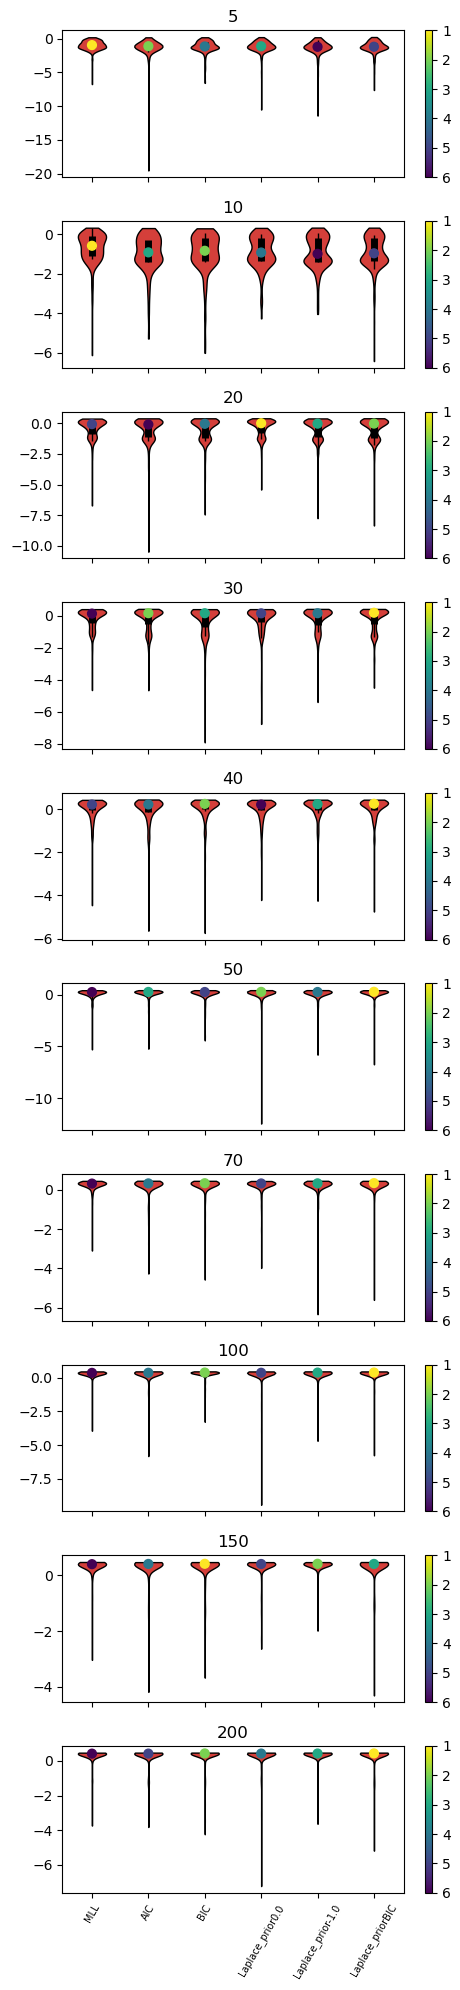

In [ ]:
with open("evaluation/temp_storage/test_likelihood_performance_dict.pickle", "rb") as f:
    test_likelihood_performance_dict = pickle.load(f)

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

# Check the entry "MCMC approx" in the result dictionary and draw a violin plot for the found models (with different colors for different dataset sizes!)
fig, ax = plt.subplots(len(test_likelihood_performance_dict))
fig.set_figheight(20)
fig.set_figwidth(5)

colors = ["green", "blue"]
positions = [i for i in range(6)]
for i, data_num in enumerate(test_likelihood_performance_dict):
    violin_data = list()
    xlabels = list()
    for pos, metric in enumerate(test_likelihood_performance_dict[data_num]):
        # Create the list of vectors for the violinplot
        #violin_data.append([m for m in test_likelihood_performance_dict[data_num][metric] if not np.isnan(m)])
        violin_data.append(np.nan_to_num(test_likelihood_performance_dict[data_num][metric]))
        xlabels.append(metric)
    parts = ax[i].violinplot(
            violin_data, positions, showmeans=False, showmedians=False,
            showextrema=False)

    for pc in parts['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    quartile1, medians, quartile3 = np.nanpercentile(violin_data, [25, 50, 75], axis=1)
    means = np.nanmean(violin_data, axis=1)
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(violin_data, quartile1, quartile3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

    medians_ranking = [sorted(medians, reverse=True).index(x) if not np.isnan(x) else 5 for x in medians]
    medians_ranking = [m+1 for m in medians_ranking] 
    s = ax[i].scatter(positions, medians, marker='o', c=medians_ranking, cmap="viridis_r", s=40, zorder=3)
    #s = ax[i].scatter(positions, medians, marker='o', c=medians, cmap="viridis", s=40, zorder=3)
    ax[i].vlines(positions, quartile1, quartile3, color='k', linestyle='-', lw=5)
    ax[i].vlines(positions, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

    ax[i].set_xticks(positions)
    ax[i].set_title(f"{data_num}")
    if i == len(test_likelihood_performance_dict)-1:
        ax[i].set_xticklabels(xlabels, rotation=60, fontsize=7)
    else:
        ax[i].set_xticklabels([])
    #ax.scatter(np.ones_like(test_likelihood_performance_dict[data_num][metric])*pos, mcmc_performance_dict[data_num][metric],  color=colors[i])
    cbar = fig.colorbar(s)
    cbar.ax.invert_yaxis()

fig.tight_layout()

## model evidence

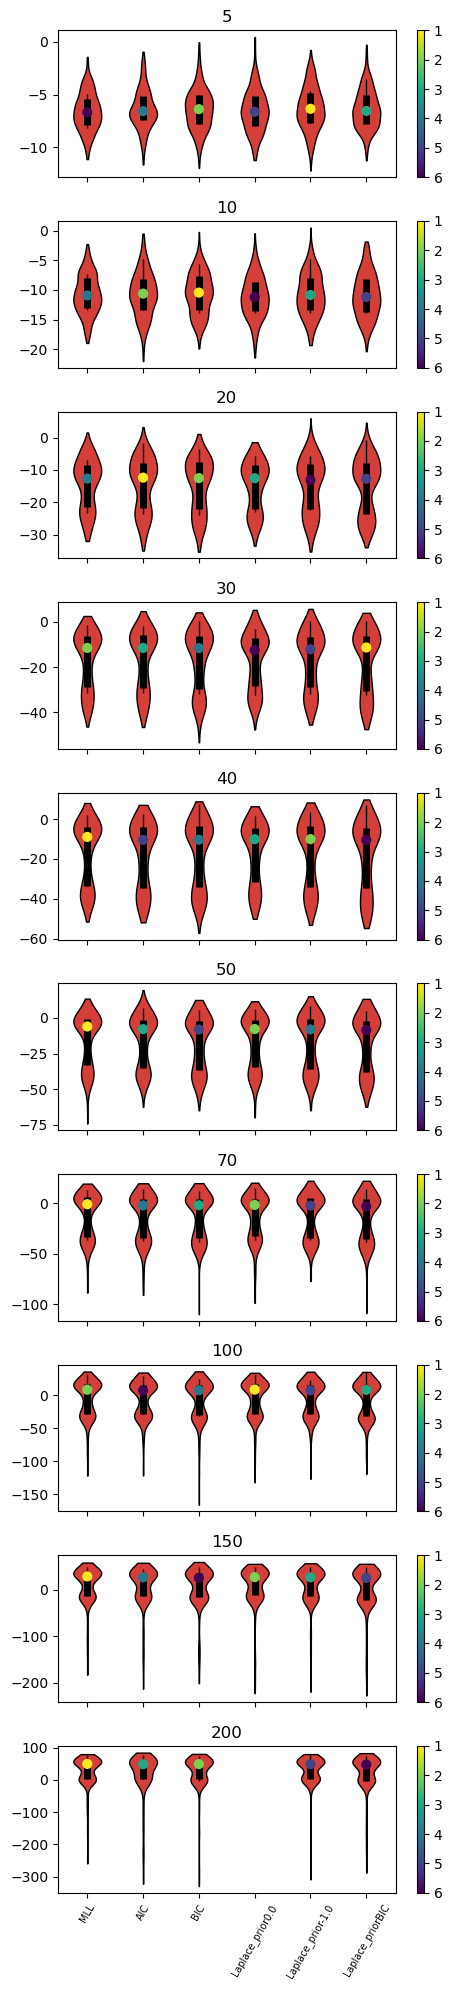

In [ ]:
with open("evaluation/temp_storage/mcmc_performance_dict.pickle", "rb") as f:
    mcmc_performance_dict = pickle.load(f)

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

# Check the entry "MCMC approx" in the result dictionary and draw a violin plot for the found models (with different colors for different dataset sizes!)
fig, ax = plt.subplots(len(mcmc_performance_dict))
fig.set_figheight(20)
fig.set_figwidth(5)

colors = ["green", "blue"]
positions = [i for i in range(6)]
for i, data_num in enumerate(mcmc_performance_dict):
    violin_data = list()
    xlabels = list()
    for pos, metric in enumerate(mcmc_performance_dict[data_num]):
        # Create the list of vectors for the violinplot
        violin_data.append(mcmc_performance_dict[data_num][metric])
        xlabels.append(metric)
    parts = ax[i].violinplot(
            violin_data, positions, showmeans=False, showmedians=False,
            showextrema=False)

    for pc in parts['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    quartile1, medians, quartile3 = np.percentile(violin_data, [25, 50, 75], axis=1)
    means = np.mean(violin_data, axis=1)
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(violin_data, quartile1, quartile3)])
    whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

    medians_ranking = [sorted(medians, reverse=True).index(x) if not np.isnan(x) else 5 for x in medians]
    medians_ranking = [m+1 for m in medians_ranking] 
    s = ax[i].scatter(positions, medians, marker='o', c=medians_ranking, cmap="viridis_r", s=40, zorder=3)
    #s = ax[i].scatter(positions, medians, marker='o', c=medians, cmap="viridis", s=40, zorder=3)
    ax[i].vlines(positions, quartile1, quartile3, color='k', linestyle='-', lw=5)
    ax[i].vlines(positions, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

    ax[i].set_xticks(positions)
    ax[i].set_title(f"{data_num}")
    if i == len(mcmc_performance_dict)-1:
        ax[i].set_xticklabels(xlabels, rotation=60, fontsize=7)
    else:
        ax[i].set_xticklabels([])
    #ax.scatter(np.ones_like(mcmc_performance_dict[data_num][metric])*pos, mcmc_performance_dict[data_num][metric],  color=colors[i])
    cbar = fig.colorbar(s)
    cbar.ax.invert_yaxis()

fig.tight_layout()

In [ ]:
#print([kernel for kernel in [ 'AIC', 'BIC', 'Laplace_2.0' 'Laplace_prior_0.0', 'Laplace_prior_BIC']])
print(" & ".join([k for k in results_dict[5]]))
for data_num in results_dict:
    #print(f"RR \\@ {data_num} & {' & '.join([str(100*results_dict[data_num][kernel]['Recognized']/results_dict[data_num][kernel]['Total']) for kernel in [  'AIC', 'BIC', 'Laplace_2.0' , 'Laplace_prior_0.0', 'Laplace_prior_BIC']])} \\\\")
    print(f"RR \\@ {data_num} & {' & '.join([str(100*results_dict[data_num][kernel]['Recognized']/results_dict[data_num][kernel]['Total']) for kernel in results_dict[data_num]])} \\\\")


In [ ]:
drawing_dataset = [list() for i in range(5)]
for i, data_num in enumerate(results_dict):
    keys = list(results_dict[data_num])
    for key in results_dict[data_num]:
        drawing_dataset[i].append(results_dict[data_num][key]["Recognized"])
plt.plot([10, 20, 50], drawing_dataset, marker='o', label=keys)
plt.ylabel("Recognized kernels")
plt.xlabel("Dataset size")
plt.legend(loc="upper right", bbox_to_anchor=(0.4, 0.0, 1, 1))
plt.savefig("evaluation/Recognized_kernels_per_datasets.png")

In [ ]:
len(all_results)

In [ ]:
for i, key in enumerate(kernel_distributions):
    fig, axs = plt.subplots(figsize=(15, 3))
    label_count = {}
    for kernel in sorted(kernel_distributions[key], key=len, reverse=False):
        kernel_name = kernel.split("=")[-1][1:]
        label_count[kernel_name] = len(kernel_distributions[key][kernel])
    axs.bar(range(len(label_count.keys())), label_count.values())
    axs.set_title(key)
    plt.xticks(range(len(label_count.keys())), label_count.keys(), rotation="vertical")


In [ ]:
#  The behaviour of the negative correction subtracted from the MAP resp. MLL values
key = "Laplace"
all_results = load_results('results', key)
#result_tree = generate_tree_structure(all_results[0]).descendants
all_results = group_by(all_results, '/results/attributes/parameter_punishment')
fig, axs = plt.subplots(1, 3, sharey=True)
for col, punish_level in enumerate(all_results):
    num_replaced_list = list()
    punish_term_list = list()
    param_num_list = [list() for i in range(0, 11, 1)]
    for result in all_results[punish_level]:
        details = deep_dict_get(result, "/results/results/details")
        # iterate over all kernels that were tried in the kernel search
        for tried_kernel in details:
            param_num_list[tried_kernel["num_replaced"]].append(
                tried_kernel["punish term"].item())
                #num_replaced_list.append(tried_kernel["num_replaced"])
                #punish_term_list.append(tried_kernel["punish term"][0][0])
    #axs[col].scatter(num_replaced_list, punish_term_list, marker=".")
    axs[col].boxplot(param_num_list, positions=range(0, 11, 1), showfliers=False)
    axs[col].plot([0,10], [0, 0], color="red", linewidth=0.5)
    axs[col].set_title(f"{punish_level.split('=')[-1]}")
    axs[col].set_xlabel("Replaced values")
    if col == 0:
        axs[col].set_ylabel("Punish term")
fig.set_figwidth(13)
fig.set_figheight(3)
tikzplotlib.save(f"evaluation/negative_correction_{key}_boxplot.tex")

In [ ]:
# The distribution of replaced parameters over the number of available parameters
key = "Laplace"
all_results = load_results('results', key)
#result_tree = generate_tree_structure(all_results[0]).descendants
all_results = group_by(all_results, '/results/attributes/parameter_punishment')
fig, axs = plt.subplots(1, 3, sharey=True)
for col, punish_level in enumerate(all_results):
    param_num_list = [list() for i in range(0, 11, 1)]
    for result in all_results[punish_level]:
        details = deep_dict_get(result, "/results/results/details")
        # iterate over all kernels that were tried in the kernel search
        for tried_kernel in details:
            param_num_list[len(tried_kernel["parameter list"])].append(
                tried_kernel["num_replaced"])
    #axs[col].scatter(num_replaced_list, punish_term_list, marker=".")
    axs[col].boxplot(param_num_list[3:], positions=range(3, 11, 1), showfliers=False)
    #axs[col].plot([0,max(num_replaced_list)], [0, 0], color="red")
    axs[col].set_title(f"{punish_level.split('=')[-1]}")
    axs[col].set_xlabel("Num. parameters")
    if col == 0:
        axs[col].set_ylabel("Num. replaced")
fig.set_figwidth(13)
fig.set_figheight(3)
tikzplotlib.save(f"evaluation/replaced_params_{key}.tex")

In [ ]:
# Boxplots over the number of parameters that each metric allows over the dataset sizes (i.e. kernel sizes)
kernel_distributions = {}
keys = ["MLL", "AIC", "BIC", "Laplace", "Laplace_prior"]
for data_num in [10, 50, 100, 250, 500]:
    print(data_num)
    num_param_list = [list() for i in range(len(keys))] 
    for i, key in enumerate(keys):
        print(key)
        all_results = load_results('results', key)
        datasize_filtered = group_by_multiple(all_results, {'/results/attributes/eval_COUNT': data_num})
        for result in datasize_filtered[list(datasize_filtered.keys())[0]]:
            parameters = deep_dict_get(result, "/results/results/parameters")
            num_param_list[i].append(len(parameters))
            # iterate over all kernels that were tried in the kernel search
    plt.violinplot(num_param_list)
    plt.title(f"Kernel sizes for {data_num} datapoints")
    plt.xlabel("Metric")
    plt.ylabel("Kernel size")
    plt.savefig(f"evaluation/kernel_sizes_{data_num}_violin.png")
    plt.close()


In [ ]:
# 
dataset_sizes = [10, 20, 30, 40, 50, 70, 100, 150, 200]
kernel_distributions = {}
#key = "Laplace_prior"
#all_results = load_results('results', key)
#result_tree = generate_tree_structure(all_results[0]).descendants
#avg_additional_punish = list()#[list() for i in range(0, 11, 1)]
#param_num_list = list()#[list() for i in range(0, 11, 1)] 
#punish_without_repl_list = [list() for i in range(0, 11, 1)] 
## Filter by the level of punishment, is this the same behaviour across all 3 levels?
#punish_val = "BIC"
#filtered_by_param_punish = group_by(all_results, '/results/attributes/parameter_punishment', punish_val)
#fig, axs = plt.subplots(1, len(dataset_sizes), sharey=True)
for key in ["Laplace", "Laplace_prior", "BIC", "AIC"]:
    all_results = load_results('results', key)
    if key in ["Laplace_prior"]:
    for punish_val in [0.0, 2.0, "BIC"]:
        print(punish_val)
        print(key)
        result_tree = generate_tree_structure(all_results[0]).descendants
        avg_additional_punish = list()#[list() for i in range(0, 11, 1)]
        param_num_list = list()#[list() for i in range(0, 11, 1)] 
        punish_without_repl_list = [list() for i in range(0, 11, 1)] 
        # Filter by the level of punishment, is this the same behaviour across all 3 levels?
        filtered_by_param_punish = group_by(all_results, '/results/attributes/parameter_punishment', punish_val)
        fig, axs = plt.subplots(1, len(dataset_sizes), sharey=True)
        for i, data_num in enumerate(dataset_sizes):
            print(data_num)
            group_by_size = group_by(filtered_by_param_punish[list(filtered_by_param_punish.keys())[0]], '/results/attributes/eval_COUNT', data_num)
            avg_additional_punish = list()#[list() for i in range(0, 11, 1)]
            param_num_list = list()#[list() for i in range(0, 11, 1)] 
            for result in group_by_size[list(group_by_size.keys())[0]]:
                details = deep_dict_get(result, "/results/results/details")
                # iterate over all kernels that were tried in the kernel search
                for tried_kernel in details:
                    if key == "Laplace":
                        new_val = (tried_kernel["punish without replacement"] - tried_kernel["punish term"])[0][0]#/tried_kernel["num_replaced"])
                    else:
                        new_val = (tried_kernel["punish without replacement"] - tried_kernel["punish term"])#/tried_kernel["num_replaced"])
                    if not new_val > 10000:
                        avg_additional_punish.append(new_val) 
                        param_num_list.append(len(tried_kernel["parameter list"]))
                    #punish_without_repl_list[len(tried_kernel["parameter list"])].append(tried_kernel["punish without replacement"])
                    #param_num_list[len(tried_kernel["parameter list"])].append(tried_kernel["num_replaced"])
            #plt.violinplot(param_num_list[3:], positions=range(3, 11))
            print(f"Total tried kernels: {len(avg_additional_punish)} - NaNs: {torch.count_nonzero(torch.Tensor([torch.isnan(p) for p in avg_additional_punish]))}")
            axs[i].scatter(param_num_list, avg_additional_punish)
            axs[i].plot([2.9,9.1], [0,0], color="red")
            #print(avg_additional_punish)
            #param_num_list

        fig.set_figwidth(20)
        fig.set_figheight(4)
            
        #plt.ylabel("oldHessian punish - newHessian punish")
        axs[0].set_ylabel("oldHessian punish - newHessian punish")
        axs[2].set_xlabel("num parameters")
        plt.savefig(f"evaluation/param_punish_difference_{key}_level_{punish_val}.png")
        plt.close()

In [ ]:
# Verify the recognition ratio of "PER", "MAT32", "PER*SE", "PER+SE", "MAT32*PER", "MAT32+PER"
keys = ["AIC", "MLL", "Laplace", "BIC"]
all_keys = keys + ["Laplace_prior"]
kernel_distributions = {}
avg_mlls = {key:list() for key in all_keys} 
avg_mlls_retrained = {key:list() for key in keys}
for key in keys:
    print(key)
    all_results = load_results('results', key, regex_scheme="0.pickle")
    result_tree = generate_tree_structure(all_results[0]).descendants
    data_num = 10
    data_500 = group_by(all_results, '/results/attributes/eval_COUNT', data_num)
    #data_0_punish = group_by(all_results, '/results/attributes/parameter_punishment', 0.0)

    for result in data_500[f"/results/attributes/eval_COUNT = {data_num}"]:
        avg_mll = deep_dict_get(result, "/results/results/avg test mll")
        if not np.isnan(avg_mll):
            if not np.isnan(torch.log(-avg_mll)):
                avg_mlls[key].append(avg_mll)
            else:
                print("THERE WAS SOMETHING POSITIVE!!!!")
print("Laplace_prior")
all_results = load_results('results', "Laplace_prior", regex_scheme="0.pickle")
result_tree = generate_tree_structure(all_results[0]).descendants
#data_500 = group_by(all_results, '/results/attributes/eval_COUNT', 500)
data_0_punish = group_by_multiple(all_results, {'/results/attributes/parameter_punishment': 0.0, '/results/attributes/eval_COUNT': data_num})

for result in data_0_punish[list(data_0_punish.keys())[0]]: #data_500["/results/attributes/eval_COUNT = 500"]:
    avg_mll = deep_dict_get(result, "/results/results/avg test mll")
    if not np.isnan(avg_mll):
        if not np.isnan(torch.log(-avg_mll)):
            avg_mlls["Laplace_prior"].append(avg_mll)
        else:
            print("THERE WAS SOMETHING POSITIVE!!!!")



        #avg_mll_retrained = deep_dict_get(result, "/results/results/avg test mll retrained")
        #if not np.isnan(avg_mll_retrained):
        #    avg_mlls_retrained[key].append(avg_mll_retrained)
plt.boxplot([avg_mlls[key] for key in all_keys], labels=[f"{key}-AVG" for key in all_keys], positions=range(len(all_keys)), showfliers=False)
#plt.violinplot([avg_mlls[key] for key in all_keys])#, labels=[f"{key}-AVG" for key in all_keys], positions=range(len(all_keys)))
#plt.boxplot([avg_mlls_retrained[key] for key in keys], labels=[f"{key}-AVG-R" for key in keys], positions=range(len(keys), 2*len(keys), 1))
plt.legend()





In [ ]:
punish_level = 2.0
for data_num in [10, 20,, 30, 40, 50]:#, 70, 100, 150, 200]:
    keys = ["AIC", "MLL", "BIC"]
    add_keys = ["Laplace_prior", "Laplace"]
    all_keys = keys + add_keys
    kernel_distributions = {}
    avg_mlls = {key:list() for key in all_keys} 
    avg_mlls_retrained = {key:list() for key in keys}
    for key in keys:
        print(key)
        all_results = load_results('results', key)#, regex_scheme="[0-9].pickle")
        result_tree = generate_tree_structure(all_results[0]).descendants
        #data_500 = group_by(all_results, '/results/attributes/Data_kernel','CO2')
        data_500 = group_by(all_results, '/results/attributes/eval_COUNT', data_num)
        #data_0_punish = group_by(all_results, '/results/attributes/parameter_punishment', 0.0)

        for result in data_500[f"/results/attributes/eval_COUNT = {data_num}"]:
            avg_mll = deep_dict_get(result, "/results/results/avg test mll")
            if not np.isnan(avg_mll):
                avg_mlls[key].append(avg_mll)
    for key in add_keys:
        print(key)
        all_results = load_results('results', key)#, regex_scheme="[0-9].pickle")
        result_tree = generate_tree_structure(all_results[0]).descendants
        data_0_punish = group_by_multiple(all_results, {'/results/attributes/parameter_punishment': punish_level, '/results/attributes/eval_COUNT': data_num})
        #data_0_punish = group_by(all_results, '/results/attributes/parameter_punishment', 0.0)

        for result in data_0_punish[list(data_0_punish.keys())[0]]:
            avg_mll = deep_dict_get(result, "/results/results/avg test mll")
            if not np.isnan(avg_mll):
                avg_mlls[key].append(avg_mll)
    #data_500 = group_by(all_results, '/results/attributes/eval_COUNT', 500)
            #avg_mll_retrained = deep_dict_get(result, "/results/results/avg test mll retrained")
            #if not np.isnan(avg_mll_retrained):
            #    avg_mlls_retrained[key].append(avg_mll_retrained)
    plt.boxplot([avg_mlls[key] for key in all_keys], labels=[f"{key}-AVG" for key in all_keys], positions=range(len(all_keys)), showfliers=False)
    #plt.violinplot([avg_mlls[key] for key in all_keys])#, labels=[f"{key}-AVG" for key in all_keys], positions=range(len(all_keys)))
    #plt.boxplot([avg_mlls_retrained[key] for key in keys], labels=[f"{key}-AVG-R" for key in keys], positions=range(len(keys), 2*len(keys), 1))
    plt.legend()
    plt.savefig(f"evaluation/{data_num}_log-likelihood_boxplot_{punish_level}-punish.png")
    plt.close()




# Kernel sizes across metrics

# Distribution of kernels per metric/data size

In [ ]:
metrics = ["Laplace0.0", "Laplace2.0", "LaplaceBIC",  "AIC", "BIC", "Laplace_prior0.0", "Laplace_prior2.0", "Laplace_priorBIC"]
keys = [ "AIC", "BIC"]
all_keys = keys + ["Laplace_prior", "Laplace"]

data_sizes = [10, 20, 30, 40, 50, 70, 100, 150, 200]

all_kernel_distributions = {data_num : {metric : {} for metric in 
                                       ["Laplace0.0", "Laplace2.0", "LaplaceBIC",  "AIC", "BIC", "Laplace_prior0.0", "Laplace_prior2.0", "Laplace_priorBIC"]}
                            for data_num in [10, 20, 30, 40, 50, 70, 100, 150, 200]}
for key in all_keys:
    print(key)
    all_results = load_results('results', key)#, regex_scheme=r_scheme)
    for data_num in data_sizes:
        data = group_by(all_results, '/results/attributes/eval_COUNT', data_num)
        data_keys = list(data.keys())
        if key in ["Laplace_prior", "Laplace"]:
            data = group_by(data[data_keys[0]], '/results/attributes/parameter_punishment') 
        for data_key in data:
            found_kernels_dict = {}
            for result in data[data_key]:
                final_model = deep_dict_get(result, 'results/results/final model')
                # Clean up kernel expression
                temp = final_model.replace("(", "")
                temp = temp.replace(")", "")
                temp = temp.replace(" ", "")
                temp = temp.replace("c*", "")
                # Sort the lists and sublists
                temp_list = [(sorted(s.split("*"))) for s in sorted(temp.split("+"))]
                final_model = "+".join(["*".join([s for s in sublist]) for sublist in temp_list])
                if not final_model in found_kernels_dict:
                    found_kernels_dict[final_model] = 1
                else:
                    found_kernels_dict[final_model] += 1
            # sanity check for number of entries
            if not sum([found_kernels_dict[k] for k in found_kernels_dict]) == 400:
                print(metric)
                print(data_num)
                print(sum([found_kernels_dict[k] for k in found_kernels_dict]))
            if key in ["Laplace_prior", "Laplace"]:
                all_kernel_distributions[data_num][f"{key}{data_key.split('=')[-1][1:]}"] = found_kernels_dict 
            else:
                all_kernel_distributions[data_num][f"{key}"] = found_kernels_dict
                


In [ ]:
all_kernel_distributions

In [ ]:
# Finding the kernel size in terms of kernel entries

simplified_kernel_distributions = {data_num : {metric : {1: 0, 2:0, 3:0} for metric in 
                                       ["Laplace0.0", "Laplace2.0", "LaplaceBIC",  "AIC", "BIC", "Laplace_prior0.0", "Laplace_prior2.0", "Laplace_priorBIC"]}
                            for data_num in [10, 20, 30, 40, 50, 70, 100, 150, 200]}
for data_num in all_kernel_distributions:
    for metric in all_kernel_distributions[data_num]:
        for found_kernel in all_kernel_distributions[data_num][metric]:
            # Get rid of all the constants
            #temp = found_kernel.replace("(", "")
            #temp = temp.replace(")", "")
            #temp = temp.replace(" ", "")
            #temp = temp.replace("c*", "")
            covar_string_list = [s.split("*") for s in found_kernel.split("+")]
            #temp_list = [(sorted([s.split("*")])) for s in sorted(found_kernel.split("+"))]
            #"+".join(["*".join([s for s in sublist]) for sublist in temp_list])
            simplified_kernel_distributions[data_num][metric][len(covar_string_list)] += all_kernel_distributions[data_num][metric][found_kernel]
        
simplified_kernel_distributions

In [ ]:
# Produce barplots for the summarized distributions
fig, axs = plt.subplots(len([10, 20, 30, 40, 50, 70, 100, 150, 200]),
                        len(simplified_kernel_distributions[10]), sharey=True)
for row, data_num in enumerate([10, 20, 30, 40, 50, 70, 100, 150, 200]):
    for col, metric in enumerate(simplified_kernel_distributions[data_num]):
        if row == 0:
            axs[row, col].set_title(metric)
        if col == 0:
            axs[row, col].set_ylabel(data_num)
        axs[row, col].bar(range(len(list(simplified_kernel_distributions[data_num][metric].keys()))),
                          [simplified_kernel_distributions[data_num][metric][k] for k in simplified_kernel_distributions[data_num][metric]],
                          tick_label=list(simplified_kernel_distributions[data_num][metric].keys()))
        #axs[row, col].tick_params('x', labelrotation=90)
        #plt.xticks(range(len(list(simplified_kernel_distributions[data_num][metric].keys()))), rotation=90)

fig.set_figwidth(15)
fig.set_figheight(10)
fig.tight_layout()
tikzplotlib.save("evaluation/kernel_distribution_summarized.tex")

In [ ]:
# Produce barplots for the detailed distributions
fig, axs = plt.subplots(4,#len(all_kernel_distributions),
                        len(all_kernel_distributions[10]), sharey=True)
#for row, data_num in enumerate(all_kernel_distributions):
#[10, 20, 30, 40, 50, 70, 100, 150, 200]
for row, data_num in enumerate([10, 20, 30, 40]):
    for col, metric in enumerate(all_kernel_distributions[data_num]):
        if row == 0:
            axs[row, col].set_title(metric)
        if col == 0:
            axs[row, col].set_ylabel(data_num)
        axs[row, col].bar(range(len(list(all_kernel_distributions[data_num][metric].keys()))),
                          [all_kernel_distributions[data_num][metric][k] for k in sorted(all_kernel_distributions[data_num][metric], key=len, reverse=False)],
                          tick_label=list(sorted(all_kernel_distributions[data_num][metric], key=len, reverse=False)))
        axs[row, col].tick_params('x', labelrotation=90)
        #plt.xticks(range(len(list(all_kernel_distributions[data_num][metric].keys()))), rotation=90)
fig.set_figwidth(30)
fig.set_figheight(15)
fig.tight_layout()

tikzplotlib.save("evaluation/kernel_distribution_small_datasizes.tex")

# Recognition ratio and avg. MLL plots/tables

In [ ]:
total_results = {data_num : {metric : {} for metric in 
                                       ["Laplace0.0", "Laplace2.0", "LaplaceBIC",  "AIC", "BIC", "Laplace_prior0.0", "Laplace_prior2.0", "Laplace_priorBIC"]}
                            for data_num in [5, 10, 20, 30, 40, 50, 70, 100, 150, 200]}

In [ ]:
#################
# Create table for evaluation
#################
keys = [ "AIC", "BIC"]# "MLL",
all_keys = keys + ["Laplace_prior", "Laplace"]
#all_keys = ["Laplace_prior"]

#datasizes = [10, 50, 100, 250, 500]
r_scheme = "[0-29].pickle"
datasizes = [5, 10, 20, 30, 40, 50, 70, 100, 150, 200]
metrics = ["AIC", "BIC", "Laplace_prior0.0", "Laplace_prior2.0", "Laplace_priorBIC", "Laplace0.0", "Laplace2.0", "LaplaceBIC"]
#param_punish = 0.0 
for key in all_keys:
    print(key)
    all_results = load_results('results', key)#, regex_scheme=r_scheme)
    result_tree = generate_tree_structure(all_results[0]).descendants
    kernel_distributions = {}
    for data_num in datasizes:
        avg_mlls = {key:list() for key in metrics} 
        if key in ["Laplace_prior", "Laplace"]:
            for param_punish in [0.0, 2.0, "BIC"]:
                data_500 = group_by_multiple(all_results, {'/results/attributes/parameter_punishment': param_punish, '/results/attributes/eval_COUNT': data_num})
                for result in data_500[list(data_500.keys())[0]]:
                    avg_mll = deep_dict_get(result, "/results/results/avg test mll")
                    if not np.isnan(avg_mll):
                        avg_mlls[f"{key}{param_punish}"].append(avg_mll)
                total_results[data_num][f"{key}{param_punish}"]["median"] = np.median(avg_mlls[f"{key}{param_punish}"])
                total_results[data_num][f"{key}{param_punish}"]["Q1"] = np.quantile(avg_mlls[f"{key}{param_punish}"], 0.33)
                total_results[data_num][f"{key}{param_punish}"]["Q3"] = np.quantile(avg_mlls[f"{key}{param_punish}"], 0.66)
        else:
            data_500 = group_by(all_results, '/results/attributes/eval_COUNT', data_num)
            for result in data_500[list(data_500.keys())[0]]:
                avg_mll = deep_dict_get(result, "/results/results/avg test mll")
                if not np.isnan(avg_mll):
                    avg_mlls[key].append(avg_mll)
            total_results[data_num][key]["median"] = np.median(avg_mlls[key])
            total_results[data_num][key]["Q1"] = np.quantile(avg_mlls[key], 0.33)
            total_results[data_num][key]["Q3"] = np.quantile(avg_mlls[key], 0.66)

AIC
BIC
Laplace_prior
Laplace


In [ ]:
total_results

{5: {'Laplace0.0': {},
  'Laplace2.0': {},
  'LaplaceBIC': {},
  'AIC': {},
  'BIC': {},
  'Laplace_prior0.0': {},
  'Laplace_prior2.0': {},
  'Laplace_priorBIC': {}},
 10: {'Laplace0.0': {'median': -0.5638637,
   'Q1': -1.2910209035873412,
   'Q3': 0.2136188599467278},
  'Laplace2.0': {'median': -0.3639787,
   'Q1': -1.3179158306121825,
   'Q3': 0.3059341037273408},
  'LaplaceBIC': {'median': -0.5293194,
   'Q1': -1.287655782699585,
   'Q3': 0.41870648562908225},
  'AIC': {'median': -0.13411152,
   'Q1': -1.3061450707912445,
   'Q3': 0.8159529554843916},
  'BIC': {'median': -0.7145959,
   'Q1': -1.465972625017166,
   'Q3': 0.39675737857818655},
  'Laplace_prior0.0': {'median': 0.14193709,
   'Q1': -1.0242484951019286,
   'Q3': 1.0462250161170963},
  'Laplace_prior2.0': {'median': -0.5900798,
   'Q1': -1.3935364830493926,
   'Q3': 0.3484532821178439},
  'Laplace_priorBIC': {'median': -0.6211333,
   'Q1': -1.3415072584152221,
   'Q3': 0.2916986995935451}},
 20: {'Laplace0.0': {'median':

AIC
BIC
Laplace_prior0.0
Laplace_prior2.0
Laplace_priorBIC
Laplace0.0
Laplace2.0
LaplaceBIC


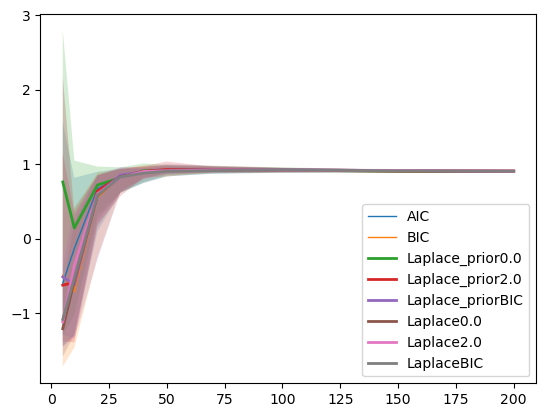

In [ ]:
# Matplotlib plot with fill between Q1 and Q3 and the median as the base values
metrics = ["Laplace"]#[ "AIC", "BIC", "Laplace_prior", "Laplace"]#"MLL",
metrics = [ "AIC", "BIC", "Laplace_prior", "Laplace"]#"MLL",
metrics = ["AIC", "BIC", "Laplace_prior0.0", "Laplace_prior2.0", "Laplace_priorBIC", "Laplace0.0", "Laplace2.0", "LaplaceBIC"]
#lines = ['', ' ', '--', '-.', '-', ':']
fig, ax = plt.subplots()
for metric in metrics:
    print(metric)
    medians = [total_results[k][metric]["median"] for k in total_results]
    lower = [total_results[k][metric]["Q1"] for k in total_results]
    upper = [total_results[k][metric]["Q3"] for k in total_results]
    x = [k for k in total_results]
    lw = 2.0 if any(text in metric for text in ["Laplace", "Laplace_prior"]) else 1.0
    ax.plot(x, medians, label=metric, linewidth=lw)
    #ax.errorbar(x, medians, yerr=[u-l for l, u in zip(lower, upper)])
    ax.fill_between(x, lower, upper, alpha=0.2)
plt.legend()
#plt.savefig("evaluation/mll_per_datapoint_full.png")
#tikzplotlib.save("evaluation/mll_per_datapoint_full.tex")

In [ ]:
print([kernel for kernel in ['AIC', 'BIC', 'Laplace_prior0.0', 'Laplace_prior2.0', 'Laplace_priorBIC', 'Laplace0.0', 'Laplace2.0', 'LaplaceBIC']])
for data_num in total_results:
    print(f"{data_num} & {' & '.join([str(total_results[data_num][kernel]['median']) for kernel in ['AIC', 'BIC', 'Laplace_prior0.0', 'Laplace_prior2.0', 'Laplace_priorBIC', 'Laplace0.0', 'Laplace2.0', 'LaplaceBIC']])} \\\\")

# CO2 dataset

In [25]:

all_results = load_results('results', 'hardcoded_CO2')

In [33]:
#all_results = load_results('results', 'hardcoded_CO2',  "results.pickle")#, regex_scheme=r_scheme)
loss_dict = {metric: list() for metric in ["AIC", "BIC", "MLL", "MAP", "Laplace_prior_0.0","Laplace_prior_-1.0","Laplace_prior_BIC", "MC", "test likelihood", "test likelihood(MAP)"]}
for result in all_results:
    for metric in ["AIC", "BIC", "MLL", "MAP", "Laplace_prior", "MC", "test likelihood", "test likelihood(MAP)"]:
        model_kernel = list(result["results"]["results"][0][metric].keys())[0]
        if metric == "Laplace_prior":
            for threshold in [0.0, -1.0, "BIC"]:
                loss = result["results"]["results"][0][metric][model_kernel][threshold]["loss"].detach().numpy()
                loss_dict[f"{metric}_{threshold}"].append((model_kernel, loss))
                print(f"{model_kernel}\t / {metric}_{threshold} : {loss}")
        elif "likelihood" in metric:
            loss = result["results"]["results"][0][metric][model_kernel].detach().numpy()
            loss_dict[f"{metric}"].append((model_kernel, loss))
        else:
            loss = result["results"]["results"][0][metric][model_kernel]["loss"].detach().numpy()
            loss_dict[f"{metric}"].append((model_kernel, loss))
            print(f"{model_kernel}\t / {metric} : {loss}")
        


(MAT32 + ((SE + PER) * SE))	 / AIC : 1417.4114990234375
(MAT32 + ((SE + PER) * SE))	 / BIC : 1391.181884765625
(MAT32 + ((SE + PER) * SE))	 / MLL : 714.7057495117188
(MAT32 + ((SE + PER) * SE))	 / MAP : 1179.126953125
(MAT32 + ((SE + PER) * SE))	 / Laplace_prior_0.0 : 1176.42066560058
(MAT32 + ((SE + PER) * SE))	 / Laplace_prior_-1.0 : 1171.42066560058
(MAT32 + ((SE + PER) * SE))	 / Laplace_prior_BIC : 1140.8970508423808
(MAT32 + ((SE + PER) * SE))	 / MC : -78277040.0
(MAT32 + (SE * PER))	 / AIC : 2406.53955078125
(MAT32 + (SE * PER))	 / BIC : 2384.681396484375
(MAT32 + (SE * PER))	 / MLL : 1208.269775390625
(MAT32 + (SE * PER))	 / MAP : 1183.0245361328125
(MAT32 + (SE * PER))	 / Laplace_prior_0.0 : 1180.3158740452675
(MAT32 + (SE * PER))	 / Laplace_prior_-1.0 : 1176.3158740452675
(MAT32 + (SE * PER))	 / Laplace_prior_BIC : 1151.1662842306298
(MAT32 + (SE * PER))	 / MC : -1894.55615234375
(MAT52 * (PER + (SE * PER)))	 / AIC : 1413.6202392578125
(MAT52 * (PER + (SE * PER)))	 / BIC : 138

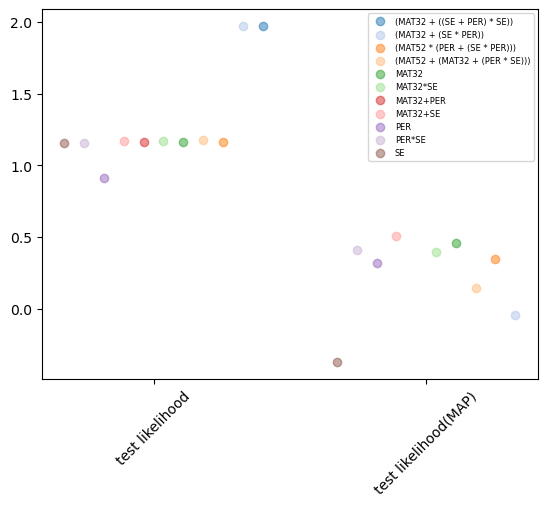

In [27]:
#all_results = load_results('results', 'hardcoded_CO2',  "results.pickle")#, regex_scheme=r_scheme)
loss_dict = {metric: list() for metric in ["test likelihood", "test likelihood(MAP)"]}
for result in all_results:
    for metric in ["test likelihood", "test likelihood(MAP)"]:
        model_kernel = list(result["results"]["results"][0][metric].keys())[0]
        if metric == "Laplace_prior":
            for threshold in [0.0, -1.0, "BIC"]:
                loss = result["results"]["results"][0][metric][model_kernel][threshold]["loss"].detach().numpy()
                loss_dict[f"{metric}_{threshold}"].append((model_kernel, loss))
                print(f"{model_kernel}\t / {metric}_{threshold} : {loss}")
        elif "likelihood" in metric:
            loss = result["results"]["results"][0][metric][model_kernel].detach().numpy()
            loss_dict[f"{metric}"].append((model_kernel, loss))
        else:
            loss = result["results"]["results"][0][metric][model_kernel]["loss"].detach().numpy()
            loss_dict[f"{metric}"].append((model_kernel, loss))
            print(f"{model_kernel}\t / {metric} : {loss}")
import matplotlib.colors as cm
colors = [cm.to_hex(plt.cm.tab20(i)) for i in range(11)]
for x, metric in enumerate(loss_dict):
    for color, model_kernel in enumerate(loss_dict[metric]):
        kernel = model_kernel[0]
        loss = model_kernel[1]
        if loss > -2000:
            plt.scatter(x - color*(0.8/len(loss_dict[metric]))+0.4, loss, c=colors[color], alpha=0.5)
plt.xticks(ticks = [i for i in range(len(loss_dict))], labels=[metric for metric in loss_dict], rotation=45)
plt.legend([model_kernel[0] for model_kernel in loss_dict["test likelihood"]], fontsize=6)
#       


In [35]:
loss_dict

{'AIC': [('(MAT32 + ((SE + PER) * SE))', array(1417.4115, dtype=float32)),
  ('(MAT32 + (SE * PER))', array(2406.5396, dtype=float32)),
  ('(MAT52 * (PER + (SE * PER)))', array(1413.6202, dtype=float32)),
  ('(MAT52 + (MAT32 + (PER * SE)))', array(1415.5236, dtype=float32)),
  ('MAT32', array(1419.4779, dtype=float32)),
  ('MAT32*SE', array(1421.9635, dtype=float32)),
  ('MAT32+PER', array(1418.6947, dtype=float32)),
  ('MAT32+SE', array(1422.6974, dtype=float32)),
  ('PER', array(-1064.7932, dtype=float32)),
  ('PER*SE', array(1415.3615, dtype=float32)),
  ('SE', array(1417.6349, dtype=float32))],
 'BIC': [('(MAT32 + ((SE + PER) * SE))', array(1391.1819, dtype=float32)),
  ('(MAT32 + (SE * PER))', array(2384.6814, dtype=float32)),
  ('(MAT52 * (PER + (SE * PER)))', array(1383.0189, dtype=float32)),
  ('(MAT52 + (MAT32 + (PER * SE)))', array(1389.294, dtype=float32)),
  ('MAT32', array(1410.7347, dtype=float32)),
  ('MAT32*SE', array(1408.8486, dtype=float32)),
  ('MAT32+PER', array(14

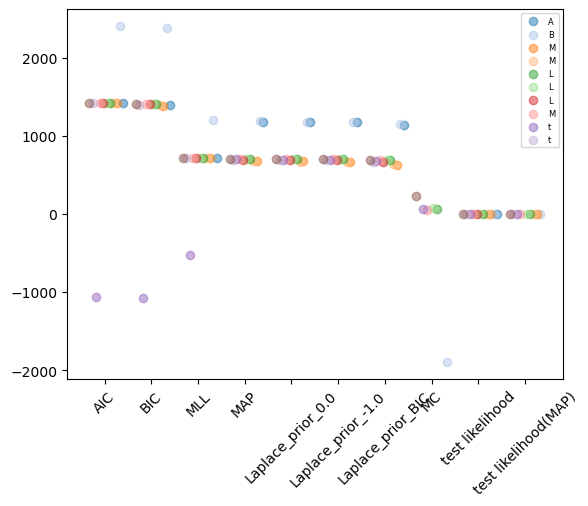

In [34]:
import matplotlib.colors as cm
colors = [cm.to_hex(plt.cm.tab20(i)) for i in range(11)]
for x, metric in enumerate(loss_dict):
    for color, model_kernel in enumerate(loss_dict[metric]):
        kernel = model_kernel[0]
        loss = model_kernel[1]
        if loss > -2000:
            plt.scatter(x - color*(0.8/len(loss_dict[metric]))+0.4, loss, c=colors[color], alpha=0.5)
plt.xticks(ticks = [i for i in range(len(loss_dict))], labels=[metric for metric in loss_dict], rotation=45)
plt.legend([model_kernel[0] for model_kernel in loss_dict], fontsize=6)
#tikzplotlib.save("evaluation/CO2_likelihood_approximations.tex")

In [36]:
loss_dict
for metric in loss_dict:
    #mc_list = [val[0] for val in sorted(loss_dict["MC"], key=lambda x:x[1], reverse=True)]
    #other_list = [val[0] for val in sorted(loss_dict[metric], key=lambda x:x[1], reverse=True)]
    #print(f"{metric}: {sorted(loss_dict[metric], key=lambda x:x[1], reverse=True)[0]}")
    mc_list = [val[1] for val in loss_dict["MC"]]
    other_list = [val[1] for val in loss_dict[metric]]
    print(f"{metric} & {np.round(scipy.stats.kendalltau(mc_list, other_list).statistic, 3)}")

AIC & 0.091
BIC & 0.236
MLL & -0.309
MAP & 0.236
Laplace_prior_0.0 & 0.2
Laplace_prior_-1.0 & 0.273
Laplace_prior_BIC & 0.273
MC & 1.0
test likelihood & -0.345
test likelihood(MAP) & 0.273


# LODE experiments

In [ ]:
#naming_schema = ["Metric", "Kernel_search", "train_data_ratio", "Data_kernel", "weights", "Variance_list", "eval_START", "eval_END", "eval_COUNT", "optimizer", "train_iterations", "LR", "Noise", "Data_scaling", "BFGS"]
all_results = load_results('results', "LODE", regex_scheme="results.pickle")
#
#postfix = ""
#result_tree = generate_tree_structure(all_results[0]).descendants


# What do I want to know?
# 1.) Does each metric recognize the correct kernels?
# 1.1.) If not: Why?
# 2.) Is the order I was talking about true?
# 2.1.) i.e. MLL > Laplace/AIC >=? MCMC
# 3.) Are models with redundant parameters more punished than others? Especially the 2SIN vs 3SIN case
# 4.) Make a ranking sheet per dataset where the models are compared _within_ a metric to see if there are similarities visible or something
#  
metrics = ["AIC", "BIC", "MLL", "MAP", {"Laplace": [0.0, 2.0, "BIC"]}, {"Laplace_prior": [0.0, 2.0, "BIC"]}]
dataset_sizes = [5, 10, 20, 30, 50, 70, 100, 150, 200] 
str_metrics = ["AIC", "BIC", "MLL", "MAP", "Laplace_0.0", "Laplace_2.0", "Laplace_BIC", "Laplace_prior_0.0", "Laplace_prior_2.0", "Laplace_prior_BIC"]

LODE_results = {dataset_size:{metric:{} for metric in str_metrics} for dataset_size in dataset_sizes}
# Iterate over all datasets
for main_dict in all_results:
    dataset_size = main_dict["results"]["attributes"]["eval_COUNT"]
    for run in main_dict["results"]["results"]:
        for metric in run:
            for model_type in run[metric]:
                if metric in ["Laplace", "Laplace_prior"]:
                    for threshold in run[metric][model_type]:
                        LODE_results[dataset_size][f"{metric}_{threshold}"][model_type] = run[metric][model_type][threshold]["loss"]
                else:
                        LODE_results[dataset_size][f"{metric}"][model_type] = run[metric][model_type]["loss"]



In [ ]:
LODE_results

{5: {'AIC': {'ideal LODE-GP': tensor(-10.2937, requires_grad=True),
   'overparameterized LODE-GP': tensor(-12.2936, requires_grad=True)},
  'BIC': {'ideal LODE-GP': tensor(-9.1220, requires_grad=True),
   'overparameterized LODE-GP': tensor(-10.7313, requires_grad=True)},
  'MLL': {'ideal LODE-GP': tensor(-2.1468, requires_grad=True),
   'overparameterized LODE-GP': tensor(-2.1468, requires_grad=True)},
  'MAP': {'ideal LODE-GP': tensor(-19.5598, requires_grad=True),
   'overparameterized LODE-GP': tensor(-23.8278, requires_grad=True)},
  'Laplace_0.0': {'ideal LODE-GP': tensor([[-11.8349]], dtype=torch.float64, requires_grad=True),
   'overparameterized LODE-GP': tensor([[-13.6089]], dtype=torch.float64, requires_grad=True)},
  'Laplace_2.0': {'ideal LODE-GP': tensor([[-11.9915]], dtype=torch.float64, requires_grad=True),
   'overparameterized LODE-GP': tensor([[-14.2745]], dtype=torch.float64, requires_grad=True)},
  'Laplace_BIC': {'ideal LODE-GP': tensor([[-12.2629]], dtype=torch.

In [ ]:
for datasize in LODE_results:
    print(datasize)
    for metric in LODE_results[datasize]:
        print(metric)
        print(f"{sorted(LODE_results[datasize][metric], key=lambda k: LODE_results[datasize][metric][k], reverse=True)}")


5
AIC
['ideal LODE-GP', 'overparameterized LODE-GP']
BIC
['ideal LODE-GP', 'overparameterized LODE-GP']
MLL
['overparameterized LODE-GP', 'ideal LODE-GP']
MAP
['ideal LODE-GP', 'overparameterized LODE-GP']
Laplace_0.0
['ideal LODE-GP', 'overparameterized LODE-GP']
Laplace_2.0
['ideal LODE-GP', 'overparameterized LODE-GP']
Laplace_BIC
['ideal LODE-GP', 'overparameterized LODE-GP']
Laplace_prior_0.0
['ideal LODE-GP', 'overparameterized LODE-GP']
Laplace_prior_2.0
['ideal LODE-GP', 'overparameterized LODE-GP']
Laplace_prior_BIC
['ideal LODE-GP', 'overparameterized LODE-GP']
10
AIC
['ideal LODE-GP', 'overparameterized LODE-GP']
BIC
['ideal LODE-GP', 'overparameterized LODE-GP']
MLL
['ideal LODE-GP', 'overparameterized LODE-GP']
MAP
['ideal LODE-GP', 'overparameterized LODE-GP']
Laplace_0.0
['overparameterized LODE-GP', 'ideal LODE-GP']
Laplace_2.0
['ideal LODE-GP', 'overparameterized LODE-GP']
Laplace_BIC
['ideal LODE-GP', 'overparameterized LODE-GP']
Laplace_prior_0.0
['ideal LODE-GP', 'o